In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import glob
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa # librosa: Audio handling package
import random
import copy
import re
import jamotools

from tqdm import tqdm_notebook as tqdm # tqdm: Pakage for progress bar visualization
from datetime import datetime

import threading
import queue

import Levenshtein as Lev

In [2]:
n_mels = 80
fs = 16000
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

# meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
# data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'

# meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
# data_folder = "D:/korean-single-speaker-speech-dataset/kss"

data_folder = "D:/nsml-dataset/train_data/"
label_path = "D:/nsml-dataset/hackathon.labels"

data_list = glob.glob(data_folder + '*.csv')[0]

wav_paths = list()
script_paths = list()
korean_script_paths = list()

with open(data_list, 'r') as f:
    for line in f:
        # line: "aaa.wav,aaa.label"
        wav_path, script_path = line.strip().split(',')
        korean_script_path = script_path.replace('.label', '.script')
        
        wav_paths.append(os.path.join(data_folder, wav_path))
        script_paths.append(os.path.join(data_folder, script_path))
        korean_script_paths.append(os.path.join(data_folder, korean_script_path))

dataset_size = len(wav_paths)

In [3]:
def get_label(filepath, bos_id, eos_id):
    key = filepath.split('/')[-1].split('.')[0]
    script = target_dict[key]
    tokens = script.split(' ')
    result = list()
    result.append(bos_id)
    for i in range(len(tokens)):
        if len(tokens[i]) > 0:
            result.append(int(tokens[i]))
    result.append(eos_id)
    return result

In [4]:
print("wav_paths len: {}".format(len(wav_paths)))
print("script_paths len: {}".format(len(script_paths)))
print("korean_script_paths len: {}".format(len(korean_script_paths)))

print(wav_paths[0])
print(script_paths[0])
print(korean_script_paths[0])

wav_paths len: 29805
script_paths len: 29805
korean_script_paths len: 29805
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.wav
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.label
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.script


In [5]:
with open(script_paths[1]) as f:
    line = f.read()
    line = line.strip()
    result = list(map(int, line.split(' ')))

In [6]:
def load_label(label_path):
    char2index = dict() # [ch] = id
    index2char = dict() # [id] = ch
    with open(label_path, 'r', encoding='UTF-8') as f:
    # with open(label_path, 'r') as f:
        for no, line in enumerate(f):
            if line[0] == '#': 
                continue

            index, char, freq = line.strip().split('\t')
            char = char.strip()
            if len(char) == 0:
                char = ' '

            char2index[char] = int(index)
            index2char[int(index)] = char

    return char2index, index2char

In [7]:
char2index, index2char = load_label(label_path)
SOS_token = char2index['<s>']  # '<sos>' or '<s>'
EOS_token = char2index['</s>']  # '<eos>' or '</s>'
PAD_token = char2index['_']  # '-' or '_'

In [8]:
korean_script_list = list()
jamo_script_list = list()

jamo_regex = re.compile(u'[,_ ^.?!？~<>:;/%()+A-Za-z0-9\u1100-\u115e\u1161-\u11A7\u11a8-\u11ff]+')

for file in tqdm(korean_script_paths):
    with open(file, 'r', encoding='utf-8') as f:
        line = f.read()
        line = line.strip()
        korean_script_list.append(line)
        jamo = jamotools.split_syllables(line, 'JAMO')
        jamo_filtered = ''.join(jamo_regex.findall(jamo))
        jamo_script_list.append(jamo_filtered)

In [9]:
class Threading_Batched_Preloader():
    def __init__(self, wav_path_list, ground_truth_list, script_path_list, batch_size, is_train=True):
        super(Threading_Batched_Preloader).__init__()
        self.wav_path_list = wav_path_list
        self.total_num_input = len(wav_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.script_path_list = script_path_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = False
        self.batch_size = batch_size
        self.queue = queue.Queue(32)
        self.thread_flags = list()
        self.is_train = is_train
    
    # Shuffle loading index and set end flag to false
    def initialize_batch(self, thread_num):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])

        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        loading_sequence_len = len(loading_sequence)
        
#         print("Loading Sequence Length: {}".format(loading_sequence_len))
        
        thread_size = int(np.ceil(loading_sequence_len / thread_num))

        load_idxs_list = list()
        for i in range(thread_num):
            start_idx = i * thread_size
            end_idx = (i + 1) * thread_size

            if end_idx > loading_sequence_len:
                end_idx = loading_sequence_len

            load_idxs_list.append(loading_sequence[start_idx:end_idx])
            
#         for i in range(thread_num):
#             print(len(load_idxs_list[i]))

        self.end_flag = False
        
        self.queue = queue.Queue(32)
        self.thread_flags = [False] * thread_num
        
        self.thread_list = [Batching_Thread(self.wav_path_list, self.ground_truth_list, self.script_path_list, load_idxs_list[i], self.queue, self.batch_size, self.thread_flags, i, self.is_train) for i in range(thread_num)]

        for thread in self.thread_list:
            thread.start()
        return

    def check_thread_flags(self):
        for flag in self.thread_flags:
            if flag == False:
                return False
        
        if (self.queue.empty):
            self.end_flag = True
            return True

        return False

    def get_batch(self):
        while not (self.check_thread_flags()):
            batch = self.queue.get()

            if (batch != None):
                batched_tensor = batch[0]
                batched_ground_truth = batch[1] 
                batched_loss_mask = batch[2]
                ground_truth_size_list = batch[3]
                lev_truth_list = batch[4]

                return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list, lev_truth_list

        return None

class Batching_Thread(threading.Thread):

    def __init__(self, wav_path_list, ground_truth_list, script_path_list, load_idxs_list, queue, batch_size, thread_flags, id, is_train=True):
        
        threading.Thread.__init__(self)
        self.wav_path_list = wav_path_list
        self.ground_truth_list = ground_truth_list
        self.script_path_list = script_path_list
        self.load_idxs_list = load_idxs_list
        self.list_len = len(load_idxs_list)
        self.cur_idx = 0
        self.id = id
        self.queue = queue
        self.batch_size = batch_size 
        self.thread_flags = thread_flags
        self.is_train = is_train

    def run(self):

        while(self.cur_idx < self.list_len):
            batch = self.batch()
            success = False
            while success == False:
                try:
                    self.queue.put(batch, True)
                    success = True
                except:
                    print("Batching Failed in Thread ID: {}".format(self.id))
                    sleep(1)

        self.thread_flags[self.id] = True
        
#         print("Thread {} finished".foramt(self.id))

        return 


    def batch(self):

        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        lev_truth_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            # If there is no more file, break and set end_flag true
            if self.cur_idx >= self.list_len:
                self.end_flag = True
                break
                
            script_path = self.script_path_list[self.load_idxs_list[self.cur_idx]]
            
#             print(script_path)
            
            with open(script_path) as f:
                line = f.read()
                line = line.strip()
                lev_truth = list(map(int, line.split(' ')))
                
            lev_truth_list.append(lev_truth)
            
            wav_path = self.wav_path_list[self.load_idxs_list[self.cur_idx]]

            tensor = self.create_mel(wav_path)
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.load_idxs_list[self.cur_idx]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.cur_idx += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order]
            
            if self.is_train:
                pad_random = np.random.randint(0, 5)
                # Time shift, add zeros in front of an image
                if pad_random > 0:
                    offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
                    target = torch.cat((offset, target), 1)
                # Add random noise
                target = target + (torch.rand(target.shape) - 0.5) / 20
                # Value less than 0 or more than 1 is clamped to 0 and 1
                target = torch.clamp(target, min=0.0, max=1.0)
                batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target
            else:
                batched_tensor[order, :tensor_size_list[order], :] = target

#           batched_tensor[order, :tensor_size_list[order], :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            
            # You do not need to know what loss mask is 
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return [batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list, lev_truth_list]
    
    def create_mel(self, wav_path):  
        y, sr = librosa.core.load(wav_path, sr=fs) 
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)

        # mel_filters: (n_fft, n_mels)
        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

        # log10(0) is minus infinite, so replace mel_specgram values smaller than 'eps' as 'eps' (1e-8)
        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        
        # 20 * log10(eps) = 20 * -8 = -160
        # -160 is the smallest value
        # Add 160 and divide by 160 => Normalize value between 0 and 1
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref        
        
        # (F, T) -> (T, F)
        input_spectrogram = norm_log_mel_specgram.T
        # (T, F) -> (1, T, F)
        # Inserted the first axis to make stacking easier
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        return tensor_input

In [10]:
# Tokenizer maps numbers to characters, 8 -> 'ㄱ', 10 -> 'ㄴ'
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [11]:
unicode_jamo_list = list()

# 초성
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))  # chr: Change hexadecimal to unicode
# 중성
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
# 종성
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
for unicode in range(ord('A'), ord('Z') + 1):
    unicode_jamo_list.append(chr(unicode))
for unicode in range(ord('a'), ord('z') + 1):
    unicode_jamo_list.append(chr(unicode))
for unicode in range(ord('0'), ord('9') + 1):
    unicode_jamo_list.append(chr(unicode))

unicode_jamo_list += [' ', '\\', '!', '~', '^', '<', '>', ',', '.', "'", '?', '？', '/', '%', '(', ')', ':', ';', '+',
                      '-', '<s>', '</s>']
unicode_jamo_list.sort()
# '_' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
unicode_jamo_list = ['_'] + unicode_jamo_list

tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [12]:
ground_truth_list = [(tokenizer.word2num(['<s>'] + list(jamo_script_list[i]) + ['</s>'])) for i in range(len(jamo_script_list))]

In [13]:
# 90% of the data will be used as train
split_index = int(0.9 * len(wav_paths))

wav_path_list_train = wav_paths[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]
script_path_list_train = script_paths[:split_index]

wav_path_list_eval = wav_paths[split_index:]
ground_truth_list_eval = ground_truth_list[split_index:]
script_path_list_eval = script_paths[split_index:]

In [14]:
batch_size = 16
num_thread = 3

preloader_eval = Threading_Batched_Preloader(wav_path_list_eval, ground_truth_list_eval, script_path_list_eval, batch_size, is_train=False)
preloader_train = Threading_Batched_Preloader(wav_path_list_train, ground_truth_list_train, script_path_list_train, batch_size)

In [15]:
def train(net, optimizer, ctc_loss, input_tensor, ground_truth, loss_mask, target_lengths):

    # Shape of the input tensor (B, T, F)
    # B: Number of a batch (8, 16, or 64 ...)
    # T: Temporal length of an input
    # F: Number of frequency band, 80

    net.train()
    
    batch_size = input_tensor.shape[0]

    optimizer.zero_grad()
    
    pred_tensor = net(input_tensor)
    
    # Cast true sentence as Long data type, since CTC loss takes long tensor only
    # Shape (B, S)
    # S: Max length among true sentences 
    truth = ground_truth
    truth = truth.type(torch.cuda.LongTensor)

    input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

    loss = ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

    loss.backward()
    optimizer.step()

    # Return loss divided by true length because loss is sum of the character losses

    return pred_tensor, loss.item() / ground_truth.shape[1]


def evaluate(net, ctc_loss, input_tensor, ground_truth, loss_mask, target_lengths):

    # Shape of the input tensor (B, T, F)
    # B: Number of a batch (8, 16, or 64 ...)
    # T: Temporal length of an input
    # F: Number of frequency band, 80

    net.eval()
    
    batch_size = input_tensor.shape[0]
    
    pred_tensor = net(input_tensor)
    
    # Cast true sentence as Long data type, since CTC loss takes long tensor only
    # Shape (B, S)
    # S: Max length among true sentences 
    truth = ground_truth
    truth = truth.type(torch.cuda.LongTensor)

    input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

    loss = ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

    # Return loss divided by true length because loss is sum of the character losses

    return pred_tensor, loss.item() / ground_truth.shape[1]

def save(model, optimizer, check_point_name):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, check_point_name)

def load(model, optimizer, check_point_name):
    checkpoint = torch.load(check_point_name)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [16]:
# Use GPU if GPU is available 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
        # (B, T, F)
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
        # (B, T, H)
        output_tensor, _ = self.gru(output_tensor)
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out, num_chars):
        super(CTC_Decoder, self).__init__()
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.5) 
        self.gru = nn.GRU(H, D_out, batch_first=True)
        self.fc = nn.Linear(D_out, num_chars)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):
        # (B, T, 2 * H/2)
        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor) 
        # (B, T, H)
        output_tensor,_ = self.gru(input_tensor)
        # (B, T, H)
        output_tensor = self.fc(output_tensor)
        # (B, T, 75)
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet(nn.Module):
    def __init__(self, D_in, H, D_out, num_chars, device):
        super(Mel2SeqNet, self).__init__()
        
        self.encoder = Encoder(D_in, H).to(device)
        self.decoder = CTC_Decoder(H, D_out, num_chars).to(device)
        
        # Initialize weights with random uniform numbers with range
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)
            
    def forward(self, input_tensor):
        batch_size = input_tensor.shape[0]
        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)
        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        return pred_tensor

In [17]:
# Function that interprets the CTC prediction result

def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem

    result = np.asarray(result)
    
    return result

In [18]:
# def label_to_string(labels):
#     if len(labels.shape) == 1:
#         sent = str()
#         for i in labels:
#             if i.item() == EOS_token:
#                 break
#             sent += index2char[i.item()]
#         return sent

#     elif len(labels.shape) == 2:
#         sents = list()
#         for i in labels:
#             sent = str()
#             for j in i:
#                 if j.item() == EOS_token:
#                     break
#                 sent += index2char[j.item()]
#             sents.append(sent)

#         return sents
    
def lev_num_to_lev_string(lev_num_list, index2char):
    lev_str_list = list()
    for num_list in lev_num_list:
        
        temp = list()
        for num in num_list:
            temp.append(index2char[num])
        
        lev_str_list.append(''.join(temp))

    return lev_str_list

def char_distance(ref, hyp):
    ref = ref.replace(' ', '') 
    hyp = hyp.replace(' ', '') 

    dist = Lev.distance(hyp, ref)
    length = len(ref.replace(' ', ''))

    return dist, length 

def char_distance_list(ref_list, hyp_list):

    sum_dist = 0
    sum_length = 0
    
    for ref, hyp in zip(ref_list, hyp_list):
        dist, length = char_distance(ref, hyp)
        sum_dist += dist
        sum_length += length

    return sum_dist, sum_length 

# def get_distance(ref_labels, hyp_labels, display=False):
#     total_dist = 0
#     total_length = 0
#     for i in range(len(ref_labels)):
#         ref = label_to_string(ref_labels[i])
#         hyp = label_to_string(hyp_labels[i])
#         dist, length = char_distance(ref, hyp)
#         total_dist += dist
#         total_length += length 
#         if display:
#             cer = total_dist / total_length
#             print('%d (%0.4f)\n(%s)\n(%s)' % (i, cer, ref, hyp))
#     return total_dist, total_length

In [19]:
# def c2i_decoding(c2i, sentence):
#     tokens = list()
#     for char in sentence:
#         try:
#             tokens.append(c2i[char])   
#         except:
# #             print(char)
#             pass
#     return tokens

def Decode_Prediction(pred_tensor, tokenizer, char2index):
    decoded_list = list()
    for i in range(pred_tensor.shape[1]):
        _, CTC_index = pred_tensor[:, i, :].max(-1)
        index = Decode_CTC_Prediction(CTC_index)
        jamos = tokenizer.num2word(index)
        sentence = jamotools.join_jamos(''.join(jamos))
        
        not_com_jamo = re.compile(u'[^\u3130-\u3190]')
        filtered_sentence = ''.join(not_com_jamo.findall(sentence))
        filtered_sentence = filtered_sentence.replace('<s>', '')
        filtered_sentence = filtered_sentence.replace('</s>', '')
#         filtered_sentence = filtered_sentence.replace('<eos>', '')
#         final_prediction = c2i_decoding(char2index, filtered_sentence)
        
        decoded_list.append(filtered_sentence)
    return decoded_list

No CER Record
Loading NSML_2nd Error
09-20 08:59:14
09-20 09:03:21
Mean Train Loss: 0.08649717292617694
Train CER: 0.9063092167842992
09-20 09:03:34
Mean Evaluation Loss: 0.07237562650692708
Evaluation CER: 0.8599603373504479


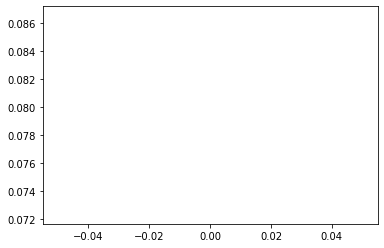

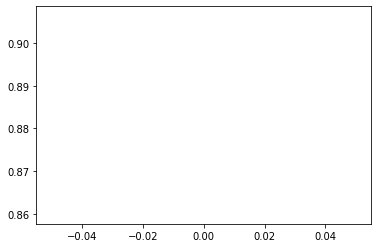

<s><s><s><s>ᄋ___________________________________________________________________________________________ᆫ나ᅡ요??</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>
<s>ᄋᆫ나요?</s>
<s>브레이크 타임 있나요?</s>___________


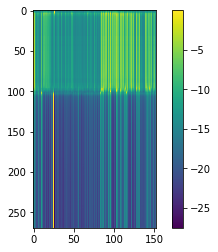

<s><s><s>ᄋ__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᆫ나ᅡ요?</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s><

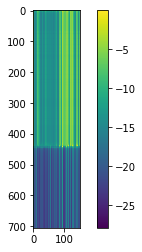

-------------------------------------------------------------------------------------------------------
09-20 09:03:35
09-20 09:07:45
Mean Train Loss: 0.07336166217772597
Train CER: 0.9253943512687823
09-20 09:07:59
Mean Evaluation Loss: 0.06950502887857186
Evaluation CER: 0.8627497984178526


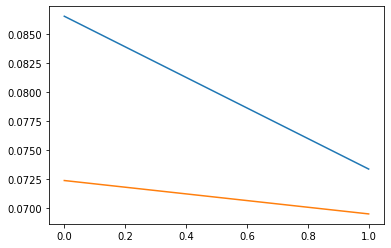

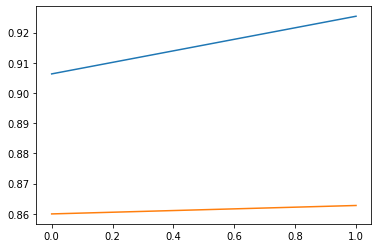

<s><s><s>아_________________________________________________________________________________________________________________________________________________________________________________________________ᅡ_ᄋ_______________________________________________________________________________________________________________________________??_______</s></s></s>__________________________________________________________________________
<s>아ᅡᄋ?</s>
<s>아닙니다. 그럼 치즈케익 메뉴도 추가 주문하고 싶습니다. 그리고 제가 직접 방문해서 받을께요.</s>____


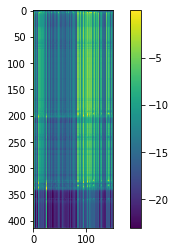

<s><s><s><s>아__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᆻ나요?</s></s>__________________________________________________________________________________________________________________________________________________________________________________
<s>았나요?</s>
<s>제가 다음주 예약을 토요일에 했는지 일요일에 했는지 헷갈려서요. 예약 확인 좀 부탁드립니다.</s>____________________________________________________________


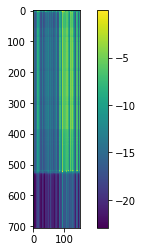

-------------------------------------------------------------------------------------------------------
09-20 09:08:00
09-20 09:12:09
Mean Train Loss: 0.0682013601947076
Train CER: 0.8581703703148912
09-20 09:12:23
Mean Evaluation Loss: 0.06684109254664246
Evaluation CER: 0.8425697910083466


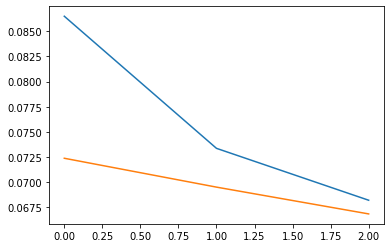

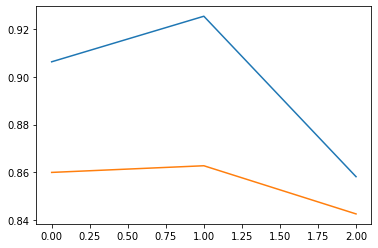

<s><s><s>아ᄋ____________________________________________________________________________________________ᅡ___________________________________________________________________________________________________________________________________________________________________________________________________________________ᅵᆫ나요?</s></s>____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
<s>아아ᅵᆫ나요?</s>
<s>춘해병원 쪽이구요. 춘해병원으로 오셔서 이 번호로 전화주시면 음식 받으러 내려가겠습니다.</s>__


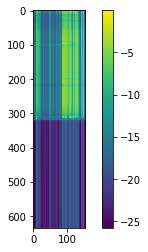

<s><s><s>아ᄋ_____________________________________________________________________________________________________________________________________________가_______________________________________________________________________________________________________________________________________가____________________________________________________________________________________________________________________인나요?</s></s>______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
<s>아ᄋ가가인나요?</s>
<s>근처에 버스 내리는 곳이 있나요? 아웃백이 강남역 5번 출구 쪽인가요? 위치가 골목 바깥 쪽인가요?</s>________________________________________________________


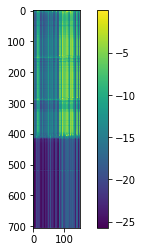

-------------------------------------------------------------------------------------------------------
09-20 09:12:24
09-20 09:16:33
Mean Train Loss: 0.07550428818881773
Train CER: 0.8798665599545227
09-20 09:16:46
Mean Evaluation Loss: 0.07167937192935254
Evaluation CER: 0.8625536644365507


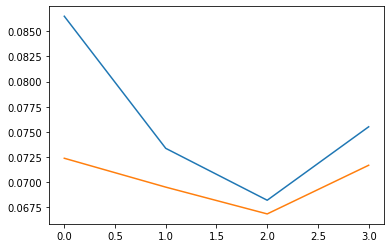

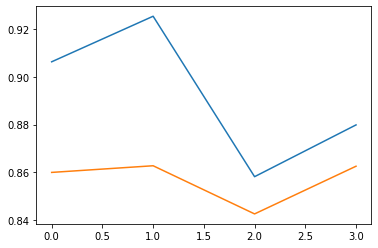

<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>_______________________________________________________________________________________________________________________________________________________________________ᆻ나요ᅭ?</s>
<s>ᆻ나요?</s>
<s>인터넷 예약은 어떻게 하는거죠?</s>_________


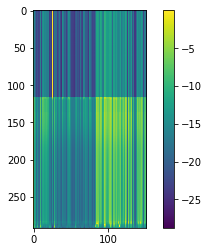

<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><

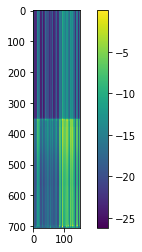

-------------------------------------------------------------------------------------------------------
09-20 09:16:47
09-20 09:20:57
Mean Train Loss: 0.06845507940091229
Train CER: 0.8569489055102586
09-20 09:21:10
Mean Evaluation Loss: 0.06671636139560998
Evaluation CER: 0.8529866846819361


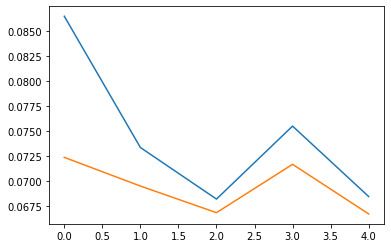

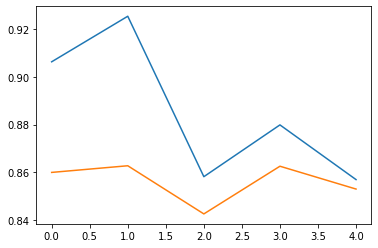

<s>아___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

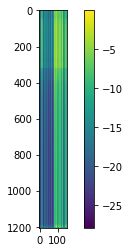

<s>아_______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᅵᆫ나요?</s>
<s>아ᅵᆫ나요?</s>
<s>삼성카드 6만원이상 결제하면 3만원 현장할인되잖아요. SKT통신사 할인도 같이 할 수 있는건가요?</s>_____________________________________________________


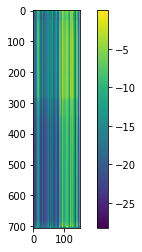

-------------------------------------------------------------------------------------------------------
09-20 09:21:11
09-20 09:25:20
Mean Train Loss: 0.06609487934043
Train CER: 0.8440760789540017
09-20 09:25:33
Mean Evaluation Loss: 0.06557057886907397
Evaluation CER: 0.8426133763375248


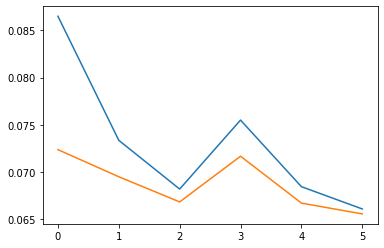

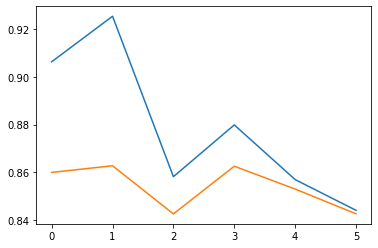

<s>아__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 안나요?</s>
<s>아 안나요?</s>
<s>오늘 런치 시간이 언제인가요?</s>_


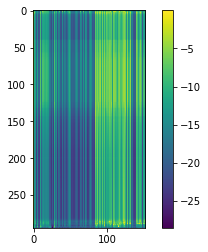

<s>아_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 안나요?</s>
<s>아 안나요?</s>
<s>제가 다음주 예약을 토요일에 했는지 일요일에 했는지 헷갈려서요. 예약 확인 좀 부탁드립니다.</s>____________________________________________________________


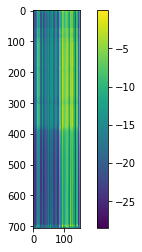

-------------------------------------------------------------------------------------------------------
09-20 09:25:34
09-20 09:29:42
Mean Train Loss: 0.0653220271009233
Train CER: 0.8452233018430075
09-20 09:29:56
Mean Evaluation Loss: 0.0652056213892208
Evaluation CER: 0.8444657528275983


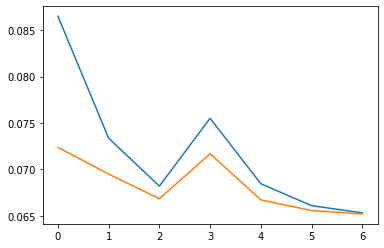

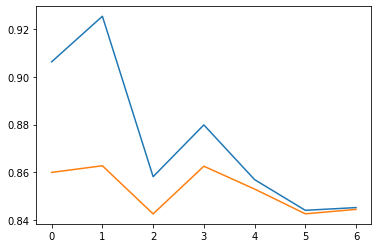

<s>아ᄋ____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 인나요?</s>
<s>아ᄋ 인나요?</s>
<s>아웃백 스페셜 서로인 하나요.</s>__


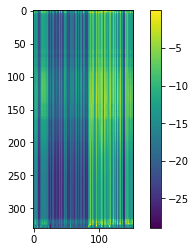

<s>아ᄋ____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 인나요?</s>
<s>아ᄋ 인나요?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


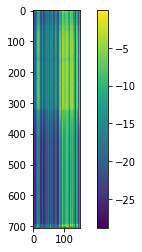

-------------------------------------------------------------------------------------------------------
09-20 09:29:57
09-20 09:34:05
Mean Train Loss: 0.06456618760727388
Train CER: 0.8473290430596976
09-20 09:34:18
Mean Evaluation Loss: 0.06458320462035327
Evaluation CER: 0.843746594896158


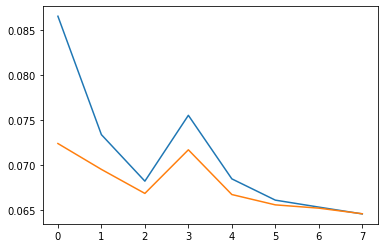

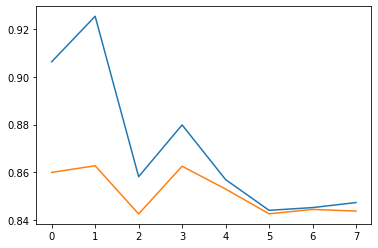

<s>아ᄋ__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 한나요?</s>
<s>아ᄋ 한나요?</s>
<s>제가 아직 초보 운전이라서 지금 저녁 시간이라 사람 많을텐데  출구 공간이 넓은가요?</s>__________


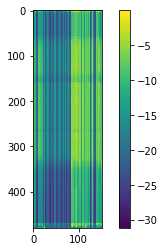

<s>아ᄋ____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 있나요?</s>
<s>아ᄋ 있나요?</s>
<s>근처에 버스 내리는 곳이 있나요? 아웃백이 강남역 5번 출구 쪽인가요? 위치가 골목 바깥 쪽인가요?</s>________________________________________________________


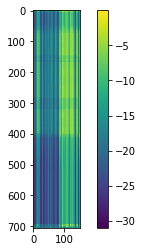

-------------------------------------------------------------------------------------------------------
09-20 09:34:19
09-20 09:38:30
Mean Train Loss: 0.0628287573394386
Train CER: 0.8409468448911993
09-20 09:38:44
Mean Evaluation Loss: 0.059410207800090896
Evaluation CER: 0.8263560485540568


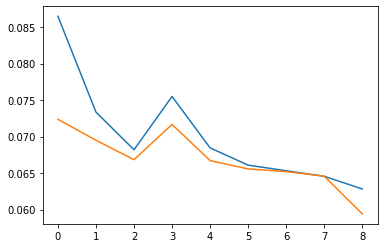

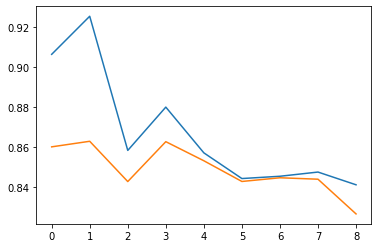

<s>안____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 인나요?</s>
<s>안 인나요?</s>
<s>예약 가능 시간은 언제인가요?</s>


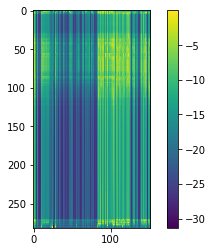

<s>안__________________________________________________________________________________________ _________________________________________________________________________________________________________________________________________________________________________ _______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 힌나요?</s>
<s>안   힌나요?</s>
<s>아웃백에 전화를 걸었을 때 점원이 여러분을 반갑게 맞이하며 인사합니다. 어떻게 답례하실건가요?</s>_______________________________________________________


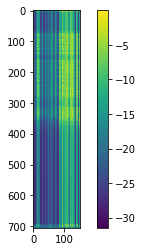

-------------------------------------------------------------------------------------------------------
09-20 09:38:45
09-20 09:42:55
Mean Train Loss: 0.05520900820662822
Train CER: 0.7987152408486501
09-20 09:43:08
Mean Evaluation Loss: 0.04925540808160924
Evaluation CER: 0.7822041100965414


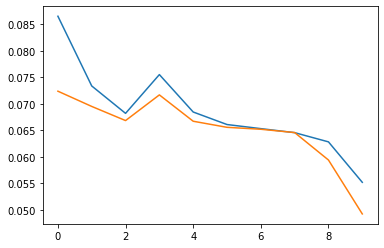

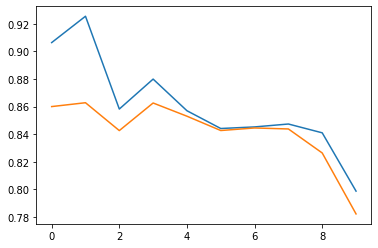

<s>아___________________________________________________________________________가_______________________________________ᅡ___ᄋ__________ᅮ_______가__________지___ᄋ__________어___ᄋ___가________ᄌ____서____모__ᄋ_____으__ᄋ_______시____고___야__________________________지_________추_____ᅥ____ᅥ___________시__오________야_____ 주___주___구____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

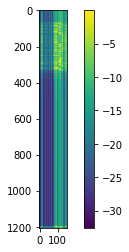

<s>아__________________________________치______아____ᅡ____아___ 시___시____ᅵ___채___ᄋ_________가_________아_____ᅳ__채____으____가_____에______ᅡ___에_________거________거____ᅮ___가____에_____이____사_______치____오_____가_____에____개___에________ 시______ᅥ_____거___제____________가______________ 가________아___아____으___가_____ᄉᄉ_______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________이_시요?</s>
<s>아치아ᅡ아 시시ᅵ채ᄋ가아ᅳ채으가에ᅡ에거거ᅮ가에이사치오가에개에 시ᅥ거제가 가아아으가ᄉ이시요?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


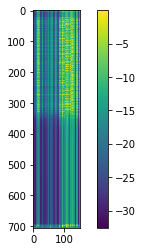

-------------------------------------------------------------------------------------------------------
09-20 09:43:09
09-20 09:47:20
Mean Train Loss: 0.047725562945379905
Train CER: 0.7661671294169347
09-20 09:47:34
Mean Evaluation Loss: 0.04346204551707361
Evaluation CER: 0.7448732756554144


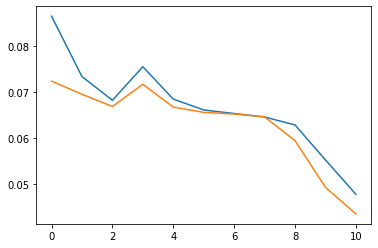

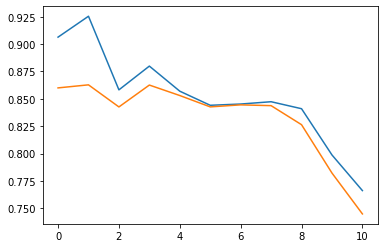

<s>아________________________________________며___ᄋ_____시______여_______어_____시_____가_____가______자_____이___이__메________________________ᅡ_____치____가_____바_____무______므______마___ᄋ______________ _지___ᅡ_________토___데__  가___라______느__ 자_________거__ 수____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᅦ요?</s>
<s>아며ᄋ시여어시가가자이이메ᅡ치가바무므마ᄋ 지ᅡ토데 가라느 자거 수ᅦ요?</s>
<s>안녕하세요.  지금 근처인데 찾지 못하고 있는데 여기서 어떻게 가야하는지 알고 싶은데요.</s>______


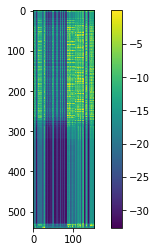

<s>아______________________________________________________________처_______________ᅥ____시_______데____ᄋ_____ᄋ____ᄋ_____시________________________________________________가___________데_____시_____  자________하________아_________ᅩ_____마______지______구___처_____지________ᅡ_________________________________________________ᅵ_____지____자________가___ᄋ___________ᅥ______가_______조____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 있나요?</s>
<s>아처ᅥ시데ᄋᄋᄋ시가데시 자하아ᅩ마지구처지ᅡᅵ지자가어가조 있나요?</s>
<s>근처에 버스 내리는 곳이 있나요? 아웃백이 강남역 5번 출구 쪽인가요? 위치가 골목 바깥 쪽인가요?</s>________________________________________________________


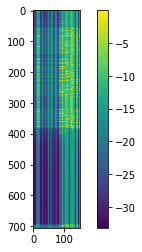

-------------------------------------------------------------------------------------------------------
09-20 09:47:35
09-20 09:51:46
Mean Train Loss: 0.04330022894991122
Train CER: 0.7324365058605184
09-20 09:51:59
Mean Evaluation Loss: 0.03999054382266833
Evaluation CER: 0.7117048401508053


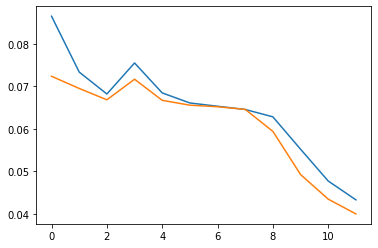

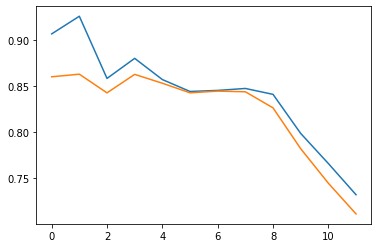

<s>이____________________________________야_____시___이___ᄋ____야_______오____가___으_____노____  이__여_____ᅮ___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________이_나요?</s>
<s>이야시이ᄋ야오가으노 이여ᅮ이나요?</s>
<s>이번 주에 예약 못하는 요일이 언젠가요?</s>_


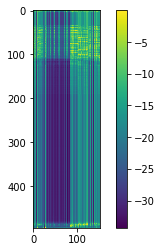

<s>아_________________________ᄅ____ᆫ__추_______ᅡ__________아___ 스____ᅦ___이___데____ᄋ__라____고_____은_모________데____느_ᆫ__바____ᄂ느_____데______________거________포_______바_____메_____이___자_____ᆫ _주____므__ᆫ__모_____네__ 드_____________ 시______고_____보___에______테__ _하____이_______ 하____느___가___가____느__ 마___ᆯ 수___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᅦ죠.</s>
<s>아ᄅᆫ추ᅡ아 스ᅦ이데ᄋ라고은모데는바느데거포바메이잔 주믄모네 드 시고보에테 하이 하느가가느 말 수ᅦ죠.</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


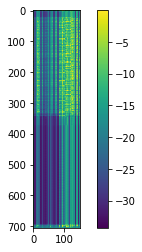

-------------------------------------------------------------------------------------------------------
09-20 09:52:00
09-20 09:56:13
Mean Train Loss: 0.04049227217572199
Train CER: 0.7013203627501897
09-20 09:56:27
Mean Evaluation Loss: 0.03761326803049363
Evaluation CER: 0.6793645259005818


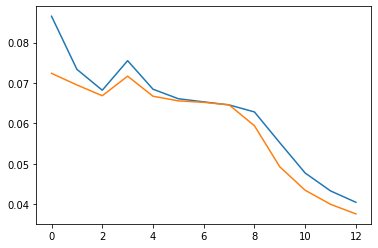

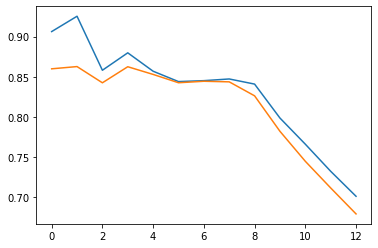

<s>아___________________________________________________________가______이___ᆫ____________________즈_________마_____ 가_____그______니_______________________________________________ _ᅵ______ᅩ________________세______ 수_________하_____ᅵ__ᅵ___다_____ᅭ_________________________________ 어________시_______게___여____하__흐______ᅳ___ᆫ___자____하_____________________________________________________________________________________________________________________________________________________ 있나요?</s>
<s>아가인즈마 가그니 ᅵᅩ세 수하ᅵᅵ다ᅭ 어시게여하흐ᅳᆫ자하 있나요?</s>
<s>연말인데 행사 같은 게 있나요? 크리스마스 때 행사 있나요? 봄 시즌에 하는 행사가 있나요?</s>______


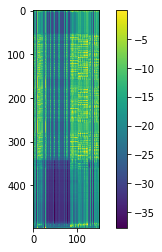

<s>애______________________________________________________________녀______________________ 사_____________지___이_________ᆨ_으___________ 자______ᅳ_______드___________________시______________________ _이___________이_____즈_____ᄂ느_____지___하____가______ᅧ_____사____료________________________________________ ᄋ_____ᄋ______________으_____져____ᅩ__ᅮ__드___다_____수_______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᅵᆸ니다.</s>
<s>애녀 사지익으 자ᅳ드시 이이즈느지하가ᅧ사료 ᄋᄋ으져ᅩᅮ드다수ᅵᆸ니다.</s>
<s>제가 다음주 예약을 토요일에 했는지 일요일에 했는지 헷갈려서요. 예약 확인 좀 부탁드립니다.</s>____________________________________________________________


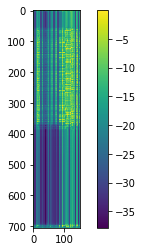

-------------------------------------------------------------------------------------------------------
09-20 09:56:28
09-20 10:00:39
Mean Train Loss: 0.03833431584287292
Train CER: 0.6739698602849219
09-20 10:00:52
Mean Evaluation Loss: 0.035585148419378064
Evaluation CER: 0.6483753568548827


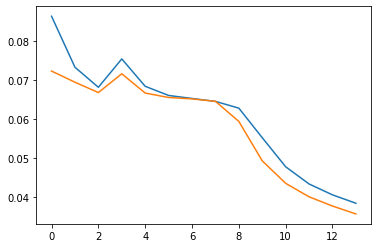

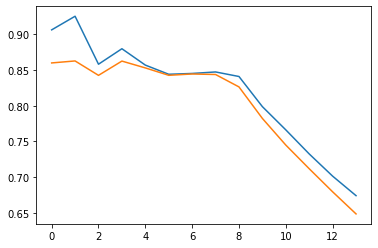

<s>아_____________________________________________이__기______카____차______치___가___이__ 가______는__데____________________________ _재_____그__데____즈__나________ᅮ____ᅩ__하_____이____그____ 가_____그____가___는ᆫ__2___고___ _가___이____나______________________________________  ᄌ__  저_________하_______________________________________________________________________________________________________________________________________________________________________________________________________________아요?</s>
<s>아이기카차치가이 가는데 재그데즈나ᅮᅩ하이그 가그가는2고 가이나 ᄌ 저하아요?</s>
<s>아이들이랑 같이 가려고하는데 키즈메뉴말고 아이들이 먹을만한게 뭐가있나요? 추천 부탁해요.</s>___


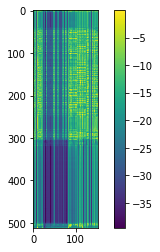

<s>아______________________________ᄅ___ᆫ___츠_______가______스_____케____ᄋ_____브____ᄒ____구_________거_____즈_ 드____그___느_____데__________________________________ 거____ᅩ_____ 거____으___이_ 사_______주____모_____거____으___드________________ _주___가____가___즈______파___ᅡ__지___  가____느_____하__ᅳ__하_ᆯ 즈___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᆸᄁᄌ죠?</s>
<s>아ᄅᆫ츠가스케ᄋ브ᄒ구거즈 드그느데 거ᅩ 거으이 사주모거으드 주가가즈파ᅡ지 가느하ᅳ할 즙ᄁ죠?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


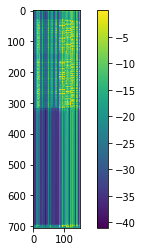

-------------------------------------------------------------------------------------------------------
09-20 10:00:53
09-20 10:05:07
Mean Train Loss: 0.03633236288336179
Train CER: 0.6475269472139152
09-20 10:05:21
Mean Evaluation Loss: 0.03350488415522092
Evaluation CER: 0.61529409200863


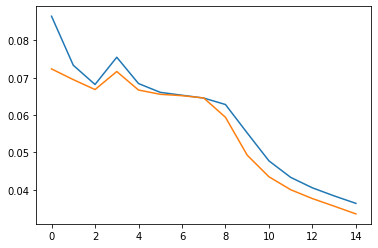

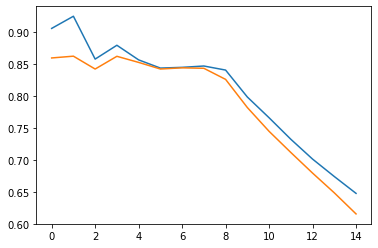

<s>아______________________________________________이___지____트___이___드______ 구_____배_____더_______________ 가_____에___바____기____이______구____그__  하____ᄀ_ _숲_으__ᆫ__데__________________________  가_____그__ _지___가_______ 가_____ᄋ____바______지_____________________ 하______시______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

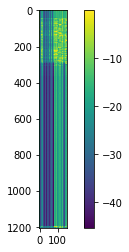

<s>오__________________________________ᆫ___추_______가___ᆯ 스______티____ᄋ_____브____에___고_____ᆫ__ 고_____즈_ 드____그___느_____데____________________________ _____ 거____고____ 거____며___이_ 서___ᆫ_  주____무_ᆫ___거____으___드________________ 주____머____가___즈______ᅡ___하__지___  가____느_____가_____가___스____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᄌᄌ죠?</s>
<s>온추갈 스티ᄋ브에곤 고즈 드그느데  거고 거며이 선 주문거으드 주머가즈ᅡ하지 가느가가스죠?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


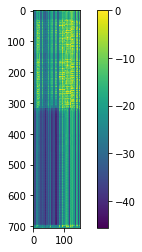

-------------------------------------------------------------------------------------------------------
09-20 10:05:22
09-20 10:09:41
Mean Train Loss: 0.034865268767670335
Train CER: 0.6290928221648199
09-20 10:09:54
Mean Evaluation Loss: 0.03232275709573839
Evaluation CER: 0.6016082986466755


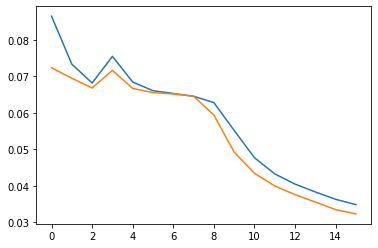

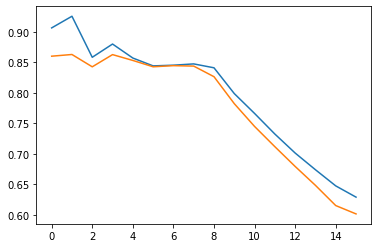

<s>지____________________________________________________________________________________고__ᆫ_시____가____이__무_ᆫ_에_____유___으________________ 머__ᆫ으ᅳ__이_ 바_______하___이_ᆫ________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 안나요?</s>
<s>지곤시가이문에유으 먼으이 바하인 안나요?</s>
<s>기브미 파이브메뉴 오늘 다 팔린건가요?</s>_____


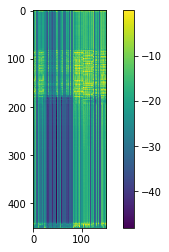

<s>어__________________________________ᆫ___츠_______아___ᆯ 스______티____ᄋ_____브_________쿠__ᄋ_____ 거_____즈__드____므___으_____데__________________________________ 어____오____ 거____으___이_ 서___ᆼ_ _주____무____ 거____으___드________________  주___무____바___즈______마______이___  가____느_____가_____가_ᆯ 스____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᄌᄌ죠?</s>
<s>언츠알 스티ᄋ브쿠ᄋ 거즈드므으데 어오 거으이 성 주무 거으드 주무바즈마이 가느가갈 스죠?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


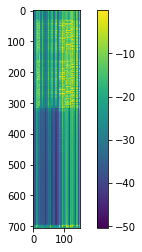

-------------------------------------------------------------------------------------------------------
09-20 10:09:55
09-20 10:14:12
Mean Train Loss: 0.03378808651070969
Train CER: 0.6134310341811348
09-20 10:14:25
Mean Evaluation Loss: 0.031326074459396704
Evaluation CER: 0.5880968466014339


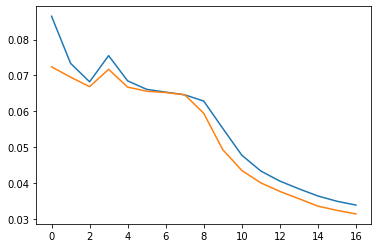

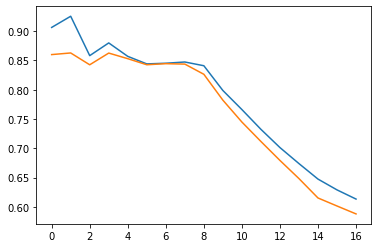

<s>어___________________________________________________________________________________________________________________________________________________________________이____오____아____예____야___하___이ᅵ__드_____느__ 대_____이___고__ 가_____려____고____하___는__데____________________ᅡ___ 어_____이_____츠______뉴____________ 하____이ᅵ__드___ 즈_____며___ᆼ_이_ _아_____드___ _타___ᆯ_이___가_______  시____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

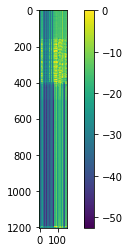

<s>그_________________________ᄅ___ᆷᆷ_ 주______가_____ 하__ᄋᄋ___ 시___케____ᅵ___크____ᄋ__ᄋ___  거________ 도_______ 즈____느_ᆫ___다____니__ᆫ__데____________  거________포______ 프_____메_____이___자____ᆫ_ 주______므_ᆫ_ 거_____느__ 트______ᄋ______ 시______고_____포___지______크__ _하____이_______ 가____느__ 가___다____느__ 마___ᆯ 수______이__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᄌᄌ죠?</s>
<s>그ᄅᆷ 주가 하ᄋ 시케ᅵ크ᄋᄋ 거 도 즈는다닌데 거포 프메이잔 주믄 거느 트ᄋ 시고포지크 하이 가느 가다느 말 수이죠?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>____________________________________________________

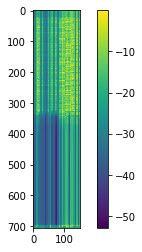

-------------------------------------------------------------------------------------------------------
09-20 10:14:26
09-20 10:18:40
Mean Train Loss: 0.03245339697614212
Train CER: 0.5971830704581942
09-20 10:18:54
Mean Evaluation Loss: 0.030188713810749973
Evaluation CER: 0.5661734260248


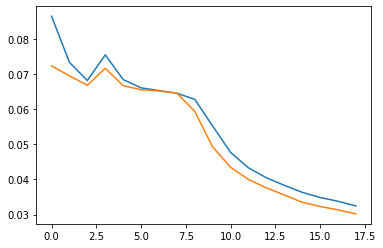

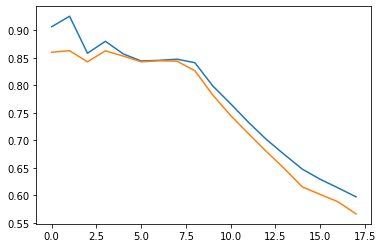

<s>네_________________________________________________저____하____이___나ᅡ______ᆫ_  타______이___다_______  그____고_____ 가____ᆫ___지_____모___ᄋ이_ 로________미__ _몌__아____________ 하ᅡ______기__________자____ 가______수____베__ 가ᅡ______티_____ _____ᆯ__수________ᅵ__ᆻᆻ느____데________ 구____이________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

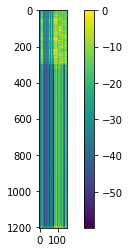

<s>아_____________________________________________우____배____ᄋ___ _저______나__ᆫ으____가______하_ᆯ 시__________데_________ 저_______오___ᆫ_이____요___요____고___느__  가_____ᄂ___가_______기_____마______지___아____여___이______사____ᅡ__ᆼ_이___아_____________ 어_____떠______데_____ 가_____ᆫ____메___하____이______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᆼᆼ한가요?</s>
<s>아우배ᄋ 저난으가할 시데 저온이요요고느 가ᄂ가기마지아여이사ᅡᆼ이아 어떠데 간메하잉한가요?</s>
<s>아웃백에 전화를 걸었을 때 점원이 여러분을 반갑게 맞이하며 인사합니다. 어떻게 답례하실건가요?</s>_______________________________________________________


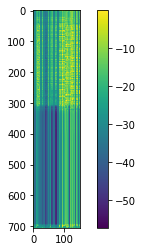

-------------------------------------------------------------------------------------------------------
09-20 10:18:54
09-20 10:23:07
Mean Train Loss: 0.031615316374663055
Train CER: 0.5864854609362518
09-20 10:23:21
Mean Evaluation Loss: 0.02988287442142045
Evaluation CER: 0.571207531544882


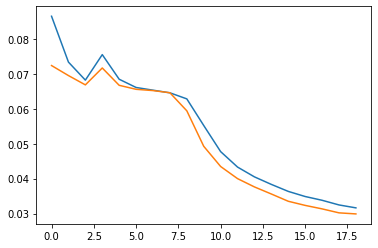

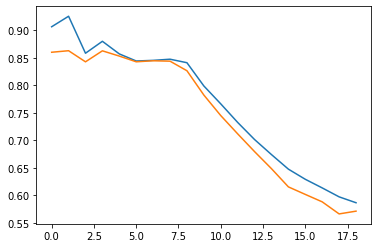

<s>주_________________________________________사______ᅡ____며________________ 주____처_____하_ᆯ_이____ᆫ_ 며_ᆾᆾ_시___아__ᆫᆫ__ 까_____이__지______________________________________________________________________________________________________________________________________________________________________________________________________________________________이_나요?</s>
<s>주사ᅡ며 주처할인 몇시안 까이지이나요?</s>
<s>식사하면 주차 할인 몇 시간까지 해주나요?</s>


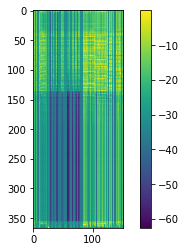

<s>어______________________________ᄅ___ᆷ___즈_______가___ᆯ 스______치____이____드_____ᅦ_ _고________ 포_____제__드____고___ᄂ__ᆫᆫ__데__________________________________ 어____도____ 거____에___뉴__저___ᆼ_  주__ᆼ_무____ 거____ᄋ____드________________ 지____모____파___즈__ᆫ___다______지___  가____ᄂ_____ 가_____가__ 스____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᄌᄌ죠?</s>
<s>어ᄅᆷ즈갈 스치이드ᅦ 고 포제드고ᄂᆫ데 어도 거에뉴정 중무 거ᄋ드 지모파즌다지 가ᄂ 가가 스죠?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


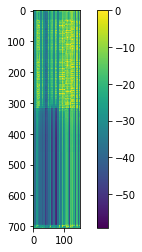

-------------------------------------------------------------------------------------------------------
09-20 10:23:22
09-20 10:27:36
Mean Train Loss: 0.03084204496457634
Train CER: 0.575897214435311
09-20 10:27:49
Mean Evaluation Loss: 0.028531185156600206
Evaluation CER: 0.5420489463246672


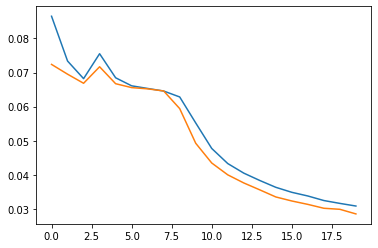

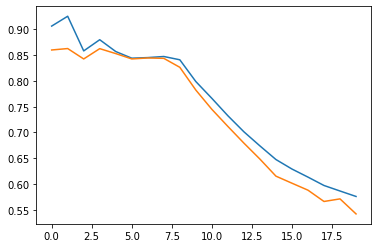

<s>이______________________________________________________인ᆫ 이__ 하___ᆯᆯ이_ᆫᆫ_______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 있아요?</s>
<s>이인 이 할인 있아요?</s>
<s>어린이 할인이 있나요?</s>_________


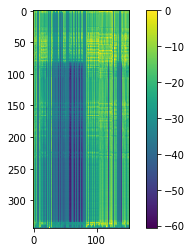

<s>오______________________________________ᆫ___뇨__ᄒ_____도___ᄅ_________ 며_____저____아_ᆯ___티______크__고_  퍼__ᆫ_하____지__라__ᆻ는ᆫ__데ᅦ___요__________________________  어_ᆨ_시____ 아____어______배_____녀_____에____모____ᄋ_ _시__은 바_____지____보__  즈___료_ 하ᅡ__드__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 되ᄂ나요?</s>
<s>온뇨ᄒ도ᄅ 며저알티크고 펀하지랐는데요 억시 아어배녀에모ᄋ 시은 바지보 즈료 하드 되나요?</s>
<s>안녕하세요. 여쭤볼게 있어서 전화드렸는데요. 혹시 아웃백에 외부 음식을 가지고 들어가도 되나요?</s>____________________________________________________________


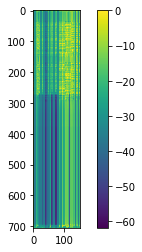

-------------------------------------------------------------------------------------------------------
09-20 10:27:49
09-20 10:32:08
Mean Train Loss: 0.029910035336303053
Train CER: 0.5635435390453365
09-20 10:32:21
Mean Evaluation Loss: 0.02812282113878445
Evaluation CER: 0.5422668729705581


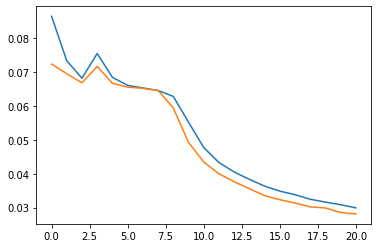

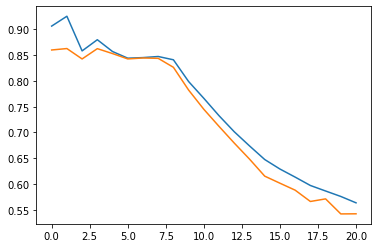

<s>며___________________________________________시_____까_______지__________져___ᆼ__여_____ᆫ  주_______문__이_ _그_____느____________________________________________________________________________________________________________________________________________________________________________ᆼᆼ한가요?</s>
<s>며시까지졍연 주문이 그능한가요?</s>
<s>몇시까지 입장해야 주문이 가능한가요?</s>___


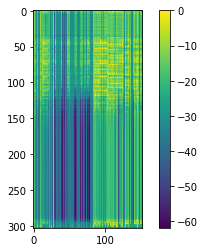

<s>아______________________________________________ᅮ____배____ᄋ___ 저______나____으_ᆯ  거______ᅩ____시______ᄋ___데________  저______우______이___여__ᄋ__ᄅ____그___으__ 가______누__가_______이__ᆫ__마___ᆫ__지__ᄋ아____ᄋ____이______자___하_ᆼ__이___가____________  어_____떠__ᆼ___기_____ 가______ᆫ___메___햐____이______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᆼ_간가요?</s>
<s>아ᅮ배ᄋ 저나을 거ᅩ시ᄋ데 저우이여ᄋᄅ그으 가누가인만지아ᄋ이자항이가 어떵기 간메햐잉간가요?</s>
<s>아웃백에 전화를 걸었을 때 점원이 여러분을 반갑게 맞이하며 인사합니다. 어떻게 답례하실건가요?</s>_______________________________________________________


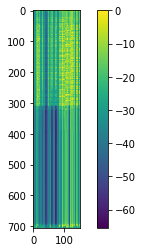

-------------------------------------------------------------------------------------------------------
09-20 10:32:22
09-20 10:36:36
Mean Train Loss: 0.029600154782259528
Train CER: 0.5581113861880328
09-20 10:36:49
Mean Evaluation Loss: 0.02724388905527324
Evaluation CER: 0.5272081417394905


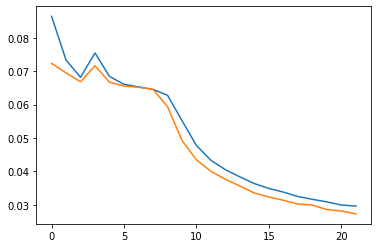

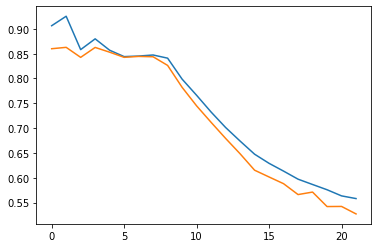

<s>이___________________________________________________ᅵ_ _주____무_ᆫ__에___느__ 메___뉴___가________________________________________________________________________________________________________________________________________________________________________________________________________________ 있나요?</s>
<s>이ᅵ 주문에느 메뉴가 있나요?</s>
<s>미리 주문되는 메뉴가 있나요</s>____


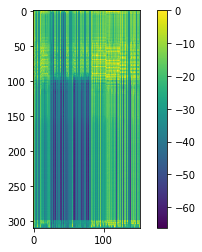

<s>그_________________________________________________________ᆫ___처______________ 버____시_______데_____이___뇨___고____시__________나________________________ __ᅵ______ 어___ᄋ________데____기____ᅵ_ 다_______려__ᆫ___이___어____  오___ᆫ__마__ᆫ__치______부____쩌_____기_____묘_____요__________________________________________ 에_ᆾ _시_____가_______오______ᄋ______ 저______까_______지__ᆷ__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 있나요?</s>
<s>근처 버시데이뇨고시나 ᅵ 어ᄋ데기ᅵ 다련이어 온만치부쩌기묘요 엧 시가오ᄋ 저까짐 있나요?</s>
<s>근처에 버스 내리는 곳이 있나요? 아웃백이 강남역 5번 출구 쪽인가요? 위치가 골목 바깥 쪽인가요?</s>________________________________________________________


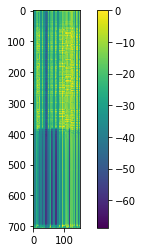

-------------------------------------------------------------------------------------------------------
09-20 10:36:50
09-20 10:41:04
Mean Train Loss: 0.028982469014579185
Train CER: 0.5504228303440017
09-20 10:41:18
Mean Evaluation Loss: 0.026649654478800546
Evaluation CER: 0.5217817682568048


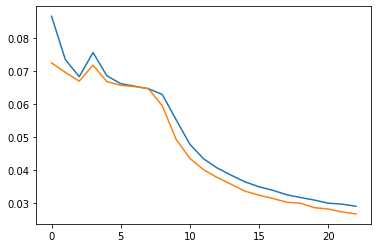

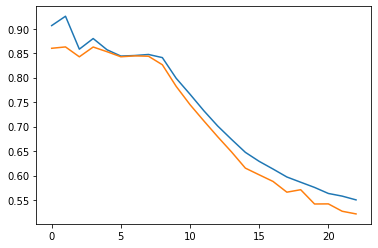

<s>아___________________________________________________________태______가________파__ 주______마____시_____쿠_____프______차____로_  시____시____에___ᆻᆻ__나__요_요__________________________________________________________   _ᅮ___ 파__ᆷ__차_____파___느______데______  시_____가__ᆫ_ 추_____아___무___스___ᆯ 수_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᅵᆻ서요?</s>
<s>아태가파 주마시쿠프차로 시시엤나요요 ᅮ 팜차파느데 시간 추아무슬 수ᅵᆻ서요?</s>
<s>카톡으로 받은 할인 쿠폰 바로 쓸 수 있나요? 쿠폰 받았는데 기간 지나도 쓸 수 있죠?</s>___________


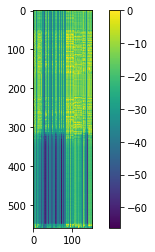

<s>고_____________________________________________________________처_______ᅦ_____  호____시_______데_____이___요___오_ᆸ__시___이_____아____요____________________________ 어___ᄋ________배____시____ᅵ_ 자_______아_ᅡᆫ__이___아__ᄋ__  이___ᆫ__바__ᆫ_ 지______부____저__ᆨ__기___묘__아__요__________________________________________  _ᅵ_ᆾ  시_____ᄀ가_______으_____료____ _저__ᆨ___가_______조__ᆫ___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________있나요?</s>
<s>고처ᅦ 호시데이요옵시이아요 어ᄋ배시ᅵ 자아ᅡᆫ이아ᄋ 인반 지부적기묘아요 ᅵᆾ 시가으료 적가존있나요?</s>
<s>근처에 버스 내리는 곳이 있나요? 아웃백이 강남역 5번 출구 쪽인가요? 위치가 골목 바깥 쪽인가요?</s>________________________________________________________


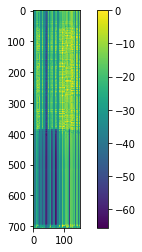

-------------------------------------------------------------------------------------------------------
09-20 10:41:19
09-20 10:45:34
Mean Train Loss: 0.0281794047821316
Train CER: 0.5407508072861471
09-20 10:45:47
Mean Evaluation Loss: 0.02608459487436447
Evaluation CER: 0.5116917645520518


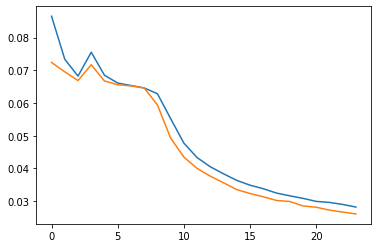

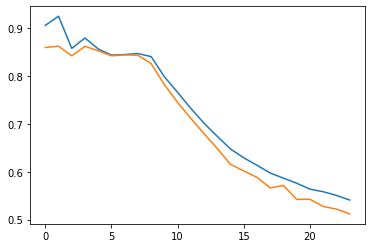

<s>하__________________________________________________ᆫ____버__ᆫᆫ___버___ᆫ___도_______________려____주_________________________________________________________________________________________________________________________________________________________________________________________________세요.</s>
<s>한번번도려주세요.</s>
<s>한번만 더 알려 주실래요?</s>____


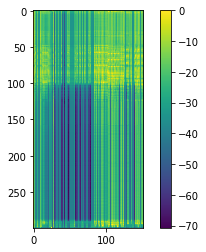

<s>어_______________________________________ᆫ__녀________더_____________ 며_____떠___ 아_ᆯ___기______커__고__ 퍼__ᆫ_마____디__라__ᆻ느_ᆫ__데ᅦ___요__________________________  어_ᆨ_시____ 아____어______배_____뉴_____에___ 머___ᆫ_  시___른 바_____지____고____더___러_ 어___드__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 되ᄂ나요?</s>
<s>언녀더 며떠 알기커고 펀마디랐는데요 억시 아어배뉴에 먼 시른 바지고더러 어드 되나요?</s>
<s>안녕하세요. 여쭤볼게 있어서 전화드렸는데요. 혹시 아웃백에 외부 음식을 가지고 들어가도 되나요?</s>____________________________________________________________


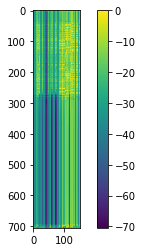

-------------------------------------------------------------------------------------------------------
09-20 10:45:48
09-20 10:50:05
Mean Train Loss: 0.028012155236669382
Train CER: 0.5353746091307067
09-20 10:50:18
Mean Evaluation Loss: 0.026036743663321045
Evaluation CER: 0.5131954584086996


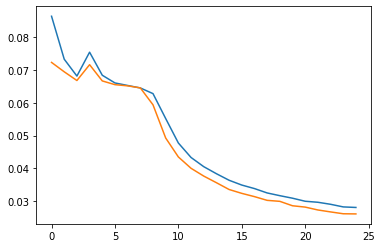

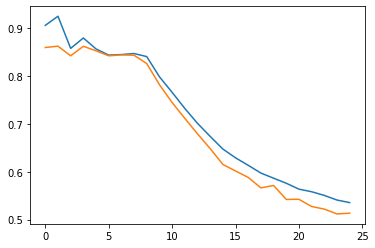

<s>처_____________________________________________________________일_ᄋ__ ᄋ__ᆨ____ᄉ____ᅵ______________ᅨ__ᄋ야ᅣ_ᆨᆨ 가______느____________________________________________________________________________________________________________________________________________________________________________________________________________ᆼᆼᄒ한가요?</s>
<s>처일ᄋ ᄋᆨ시ᅨ약 가능한가요?</s>
<s>평일 런치 예약 가능한가요?</s>__


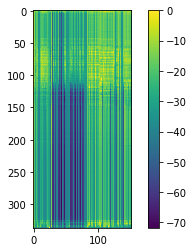

<s>오______________________________________ᆫ__녀___하____세____________ᆫ 며_____사____하_ᆯ___디_ᄋ____그__로_  퍼__ᆫ_하____디__라_ᆻᆻ느_ᆫ__데ᅦ__ᄋ요__________________________  어___시____ 아____우______배_____며_____에____머___ᆫ___시___은_다_____지____도____자___료__ 아__디__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 되ᄂ나요?</s>
<s>온녀하센 며사할디ᄋ그로 펀하디랐는데요 어시 아우배며에먼시은다지도자료 아디 되나요?</s>
<s>안녕하세요. 여쭤볼게 있어서 전화드렸는데요. 혹시 아웃백에 외부 음식을 가지고 들어가도 되나요?</s>____________________________________________________________


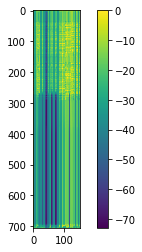

-------------------------------------------------------------------------------------------------------
09-20 10:50:19
09-20 10:54:34
Mean Train Loss: 0.027527938327437922
Train CER: 0.5319020380852036
09-20 10:54:47
Mean Evaluation Loss: 0.02605556535792286
Evaluation CER: 0.5153747248676096


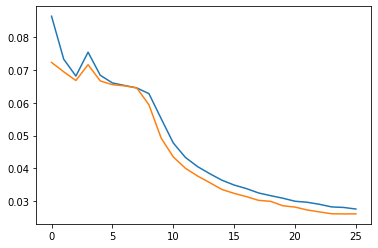

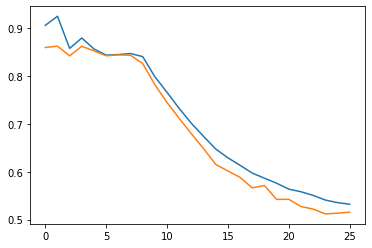

<s>하________________________________이____대___는 카______든__하________가_______________________________________________________________________________________________________________________________________________ 있ᄌ죠ᅭ?</s>
<s>하이대는 카든하가 있죠?</s>
<s>할인되는카드는뭐가있죠?</s>______


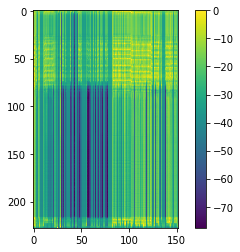

<s>거______________________________ᄅ___ᆷ___채_______사___ᆯ 스______체_____ᅵ____브_______ ___________ 고_____즈_ 드____므___니_ᆫ___데_________________________________  허____오____ 거____메___뉴__서___ᆼ_  주____므_ᆫ_ _거___으____드_______________  지____무____하___흐__ᆫ___아______이___  가____느_____가_____가_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᄌ죠ᅭ?</s>
<s>거ᄅᆷ채살 스체ᅵ브  고즈 드므닌데 허오 거메뉴성 주믄 거으드 지무하흔아이 가느가가죠?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


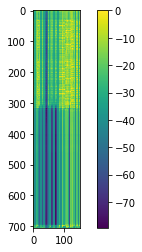

-------------------------------------------------------------------------------------------------------
09-20 10:54:48
09-20 10:59:03
Mean Train Loss: 0.02702144154910296
Train CER: 0.523367895065584
09-20 10:59:17
Mean Evaluation Loss: 0.025162357700655856
Evaluation CER: 0.49946607971756707


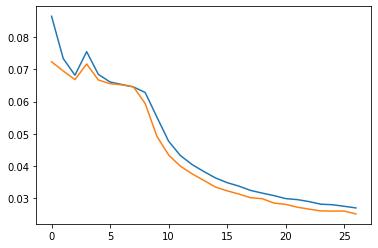

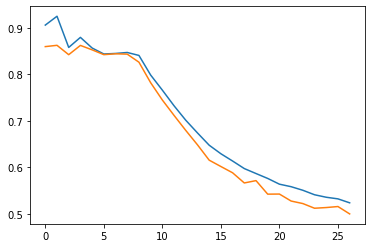

<s>어________________________________________________________________________________________________________________________________________________________________ᄅ_______이___하_____에___ᄋ_ᅣ_ 하____이__드____드_ᆫ_ 재_____지___고__ 가_____려____고_  ᄒ하__는ᆫ__데___________________ᄋ____ 서ᅥ__ᆼ__이_ᆫ_ 새___ᆫ__며______ᆼ_______아____이__드__  ᄌ______며___ᆼ_이_ ᄋ__ᅡᆫ___드___  자_____리____ᅡ______ᄋ__ᄋ_______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

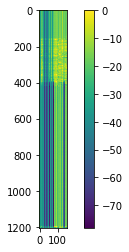

<s>아______________________________________________ᅮ____배_ᆨᆨ_이__ 저_______하___으___ 가______어___시__________때________  저_______오_____이_  ᄋᄋ_____어___으___르__ 가_______ᆼ__가_______기_____마___ᆫ__기___ᄋ_____ᄋ__ᆯ_이______져______ᆼ__이___다____________  어_____떠__ᆼ___기____  가_____ᆫᆫ___메____하___ᅵ___ᅵ_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________언가요?</s>
<s>아ᅮ백이 저하으 가어시때 저오이 ᄋ어으르 강가기만기ᄋᄋᆯ이졍이다 어떵기 간메하ᅵᅵ언가요?</s>
<s>아웃백에 전화를 걸었을 때 점원이 여러분을 반갑게 맞이하며 인사합니다. 어떻게 답례하실건가요?</s>_______________________________________________________


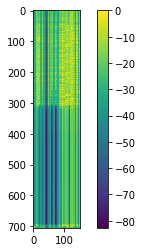

-------------------------------------------------------------------------------------------------------
09-20 10:59:17
09-20 11:03:29
Mean Train Loss: 0.02678466045469302
Train CER: 0.5207168251178398
09-20 11:03:43
Mean Evaluation Loss: 0.02510992040286223
Evaluation CER: 0.49316799965131736


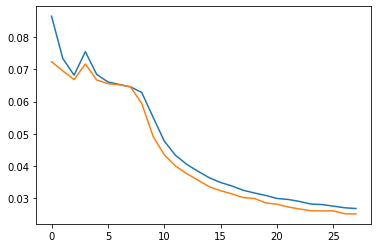

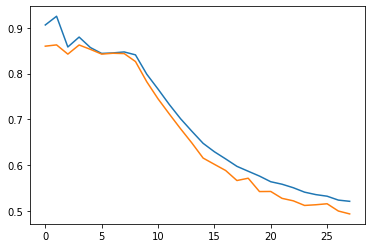

<s>고_________________________________________리__________시____ᄋ__________ᄋ아_ᆯ__려___________________________________________________________________________________________________________________________________________________________________________________________________________________________ 있어요?</s>
<s>고리시ᄋ알려 있어요?</s>
<s>거기 위치를 알려주시겠어요?</s>____


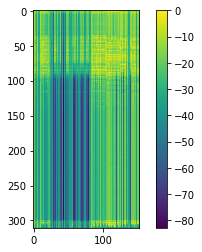

<s>그_________________________러__ᆫ___체______사_____ _ᅡ__ᄅ____ 시___테___이___테____에__ᅦ__  고________ 보________즈___느_ᆫᆫ__카____느__ᆫ___데____________  고________포____ᆫ_ 바_____며____기____저____ᆫ_ 지_____모_ᆫ___가_____느___태______________시______고_____또___스__ᆫ___크__ 하_____이___ᆫ__ 가_____느_ᆫ 하___가____는_ 마___ᆯ_수__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᄌ죠ᅭ?</s>
<s>그런체사 ᅡᄅ 시테이테에ᅦ 고 보즈는카는데 고폰 바며기전 지몬가느태시고또슨크 하인 가는 하가는 말수죠?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>______________________________________________________

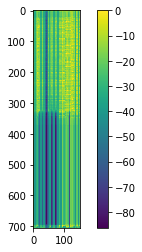

-------------------------------------------------------------------------------------------------------
09-20 11:03:43
09-20 11:07:57
Mean Train Loss: 0.026919488634284824
Train CER: 0.520748963861795
09-20 11:08:10
Mean Evaluation Loss: 0.024826973908965558
Evaluation CER: 0.4944973521912524


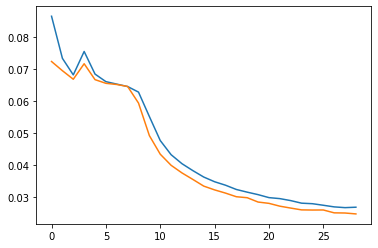

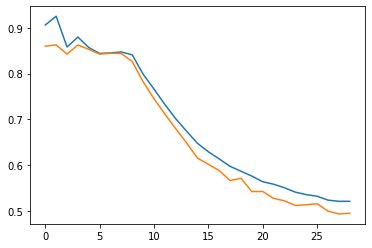

<s>이________________________________________________________버___ᆫᆫ  주____마____에_________  다____ᆫᆫ_ᄎ체___  예_야ᅣᆨ 하___ᄅ려__고_ᄒ하_ᄂᆫ__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________데요.</s>
<s>이번 주마에 단체 예약 하려고하ᄂᆫ데요.</s>
<s>이번주말에 단체예약하려고 하는데요.</s>______


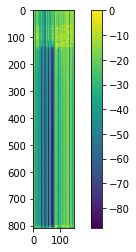

<s>차_______________________________________ᆼ_ 하_____에________ ᄋ_ᅡ_____이____나____에______에_______ᅡ____하____하_______해____혀___ᄒ______ᆫ  메___야_____________________________기_______________________________소__ᆼ_이_____마_________ᄆ__  가____지__ᄒ____ᄒ___이_ _여_ᆼ______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________언가요?</s>
<s>창 하에 아이나에에ᅡ하하해혀ᄒᆫ 메야기송이마ᄆ 가지ᄒᄒ이 영언가요?</s>
<s>삼성카드 6만원이상 결제하면 3만원 현장할인되잖아요. SKT통신사 할인도 같이 할 수 있는건가요?</s>_____________________________________________________


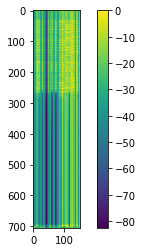

-------------------------------------------------------------------------------------------------------
09-20 11:08:11
09-20 11:12:28
Mean Train Loss: 0.025992615061758394
Train CER: 0.5112445235282683
09-20 11:12:42
Mean Evaluation Loss: 0.024070305312708304
Evaluation CER: 0.47715039117832936


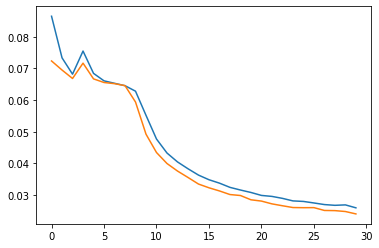

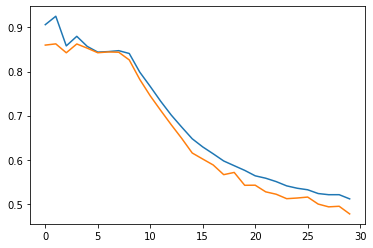

<s>아__________________________________________________이___드___이_다_____ᆼᆼ_  파_____치_  가____로_ 고 하__느_ᆫᆫ__데_________________  치_____트____메____뉴___마_ᄋ____거________  가____ᄋ이__드__으_ᆫ__부______아____나__ᆫ___제__ᄋ_____ 오_____ 가____인___나____요___________________ 우___어___ᆼ____으___파_________________________________________________________________________________________________________________________________________________________________________________________________가요?</s>
<s>아이드이당 파치 가로 고 하는데 치트메뉴마ᄋ거 가이드은부아난제ᄋ 오 가인나요 우엉으파가요?</s>
<s>아이들이랑 같이 가려고하는데 키즈메뉴말고 아이들이 먹을만한게 뭐가있나요? 추천 부탁해요.</s>____


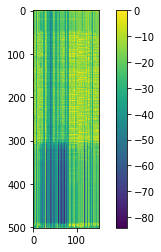

<s>아_____________________________________________우ᅮᆺ__배__ᆨ_이__ 저_______하___으_ᆯ_ 거________ᅡ_ 시______스__애____ᄋ____ 저_______어___ᆫ 이__ 오_____러___으_ᆯ_으__ 가_______ᆼ__가_______게_____마___ᆫ__이__ᄋ아____아_ᆯ 이__ᆻᆻ__자___아__ᆼ_이___가____________  어_____떠__ᇂᇂ__게_____ 가_____ᆫ____게___하____게_______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 건가요?</s>
<s>아웃백이 저하을 거ᅡ 시스애ᄋ 저언 이 오러을으 강가게만이아알 있자앙이가 어떻게 간게하게 건가요?</s>
<s>아웃백에 전화를 걸었을 때 점원이 여러분을 반갑게 맞이하며 인사합니다. 어떻게 답례하실건가요?</s>______________________________________________________

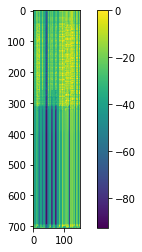

-------------------------------------------------------------------------------------------------------
09-20 11:12:43
09-20 11:16:58
Mean Train Loss: 0.02599102816627601
Train CER: 0.5089751259721698
09-20 11:17:11
Mean Evaluation Loss: 0.027406646190059766
Evaluation CER: 0.5335498071349184


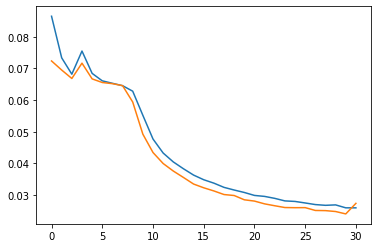

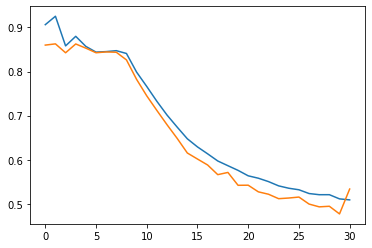

<s>가____________________________________________ᆫᆫ__치____소____우_ᆫ _며_ᆾᆾ_지_____까____지_  가___느____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᆼᆼᆼ한가요?</s>
<s>간치소운 몇지까지 가능한가요?</s>
<s>단체석은 몇인까지 가능한가요?</s>_________


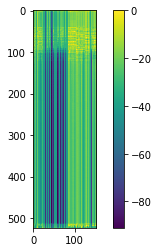

<s>처________________________________라___ᅡ__  가____ 세________ 아ᅡ___________라____ᄋ______ 아__________  가____마_______개___하__________ᆫᆫ _미___아______________________ᄅ______치_____________________________  포_ᆼ_이______하_______ᆼ 모__ 하___사______________  이__ᆼ______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________한가요?</s>
<s>처라ᅡ 가 세 아라ᄋ 아 가마개한 미아ᄅ치 퐁이항 모 하사 잉한가요?</s>
<s>삼성카드 6만원이상 결제하면 3만원 현장할인되잖아요. SKT통신사 할인도 같이 할 수 있는건가요?</s>_____________________________________________________


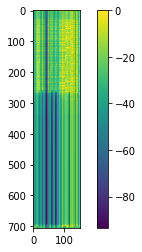

-------------------------------------------------------------------------------------------------------
09-20 11:17:12
09-20 11:21:25
Mean Train Loss: 0.02582724955441415
Train CER: 0.5050834342198869
09-20 11:21:39
Mean Evaluation Loss: 0.02380693201496378
Evaluation CER: 0.4738161134961972


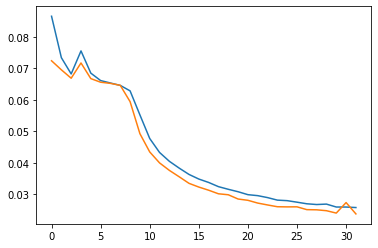

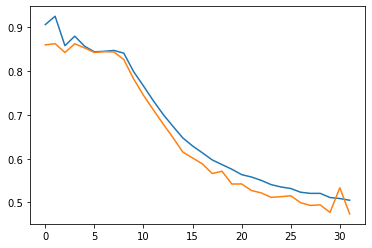

<s>차__________________________________________________퍼_____더__ᆨ__여_______채___  가_____느______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᆼᆼᄒ한가요?</s>
<s>차퍼덕여채 가능한가요?</s>
<s>상품권 결제 가능한가요?</s>____


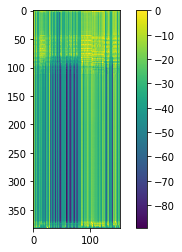

<s>아______________________________________________________________가_____________________  아_____우_ᆺᆺ___배__ ᄋ에___요___ᆨ_으__________  파_____료__ᆫ___데_____니____느___ᆫ___지_____ᅵ_______________   이__요_______이___ _세_____ᆻ느_ᆫ___시___에_ᆨ__하_____려_____거_______ᅭ_____________________________________  예_____야_ᆨᆨ_하______으_ᆫ___그____오_ᆷ  부____자_ᆨ___ᅳᅳ_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________립니다.</s>
<s>아가 아웃배 에욕으 파룐데니는지ᅵ 이요이 셌는시엑하려거ᅭ 예약하은그옴 부작ᅳ립니다.</s>
<s>제가 다음주 예약을 토요일에 했는지 일요일에 했는지 헷갈려서요. 예약 확인 좀 부탁드립니다.</s>____________________________________________________________


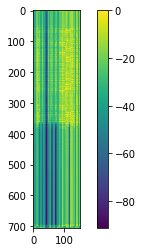

-------------------------------------------------------------------------------------------------------
09-20 11:21:40
09-20 11:25:53
Mean Train Loss: 0.025718289244242302
Train CER: 0.5044001447990912
09-20 11:26:06
Mean Evaluation Loss: 0.024089896664255542
Evaluation CER: 0.48131279011484734


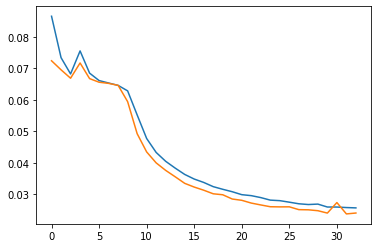

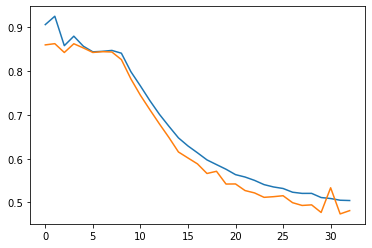

<s>지____________________________________________________________________겨_____________  예___ᄋ_야ᅣᅣᆨᆨ_ 가______ᄂ느___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᆼᆼᄒ한가요?</s>
<s>지겨 예ᄋ약 가능한가요?</s>
<s>지금 예약 가능한가요?</s>_________


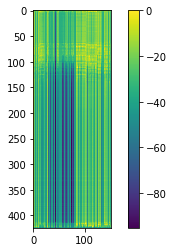

<s>처__________________________________________하______레_______ _어______에___마____에_____ _자____________ᅡ_____마___ᆼᆼ__네___녀___하____ᆫ___메___여______________________리_____기_______________________________소__ᆼ_이______마________모___가____사__하__________ 유___ᄋ________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________어요?</s>
<s>처하레 어에마에 자ᅡ망네녀한메여리기송이마모가사하 유ᄋ어요?</s>
<s>삼성카드 6만원이상 결제하면 3만원 현장할인되잖아요. SKT통신사 할인도 같이 할 수 있는건가요?</s>_____________________________________________________


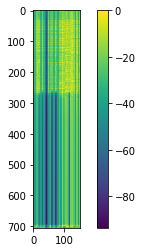

-------------------------------------------------------------------------------------------------------
09-20 11:26:07
09-20 11:30:24
Mean Train Loss: 0.025602496509757596
Train CER: 0.5024538775754492
09-20 11:30:37
Mean Evaluation Loss: 0.023914439234164198
Evaluation CER: 0.4726393096083858


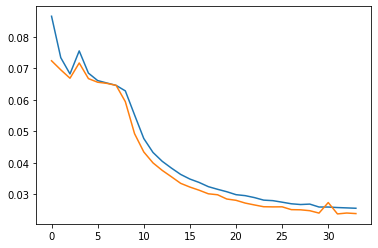

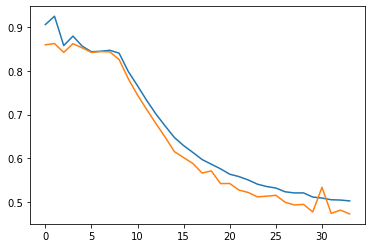

<s>호________________________________________________________ᆨᆨ_시__________________________미____이__  메____뉴___가____초____차___가_ᆯ__스___이__ᅵᆼ 우_____________________________________________________________________________________________________________________________________________________________________________________________________ᅵᅵᆻ을까요?</s>
<s>혹시미이 메뉴가초차갈스이ᅵᆼ 우ᅵᆻ을까요?</s>
<s>혹시 미리 메뉴를 선택할수 있을까요?</s>___


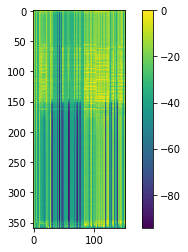

<s>오_________________________________________느____ᅡ____서___요_______ᆫ 며_____ᄄ_____하_____게__ᅵ___그__로_  버____나____기__래_ᆻᆻ느_ᆫ__데____요__________________________  혹ᆨ_시____ 아____우_ᆺ____배_____이_____에___ 머___ᆫ____시__렐 ᄀ가____지____보__  다___료__하ᅡ__도__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 되ᄂ나요?</s>
<s>오느ᅡ서욘 며ᄄ하게ᅵ그로 버나기랬는데요 혹시 아웃배이에 먼시렐 가지보 다료하도 되나요?</s>
<s>안녕하세요. 여쭤볼게 있어서 전화드렸는데요. 혹시 아웃백에 외부 음식을 가지고 들어가도 되나요?</s>____________________________________________________________


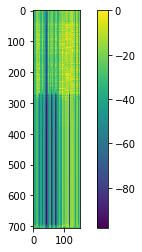

-------------------------------------------------------------------------------------------------------
09-20 11:30:38
09-20 11:34:54
Mean Train Loss: 0.02603151925146389
Train CER: 0.5103710604331244
09-20 11:35:08
Mean Evaluation Loss: 0.024008553256167044
Evaluation CER: 0.47802209776189336


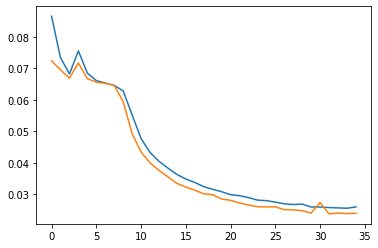

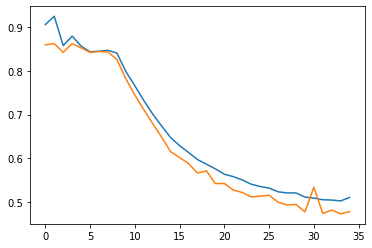

<s>아_____________________________________________________ᄒ_____느_____ 그_ᆷ___다_____ᅵ__다_________  오__ᆨ__치___ _가____데______  다____이_ᆼ__으___ᅩ_ 이__ᄋ야_ᆨ___브___는__데____________ 주____혀_ᆼ_이____어______버_ᆯ__거____가_ᇀᇀ__으__ 메____ᅵ__뉴___기_____도____ᅩ_ 가____느________________________________________________________________________________________________________________________________________________________________________________________________________________________ᆼᆼᄒ한가요?</s>
<s>아ᄒ느 금다ᅵ다 옥치 가데 다잉으ᅩ 이약브는데 주형이어벌거같으 메ᅵ뉴기도ᅩ 가능한가요?</s>
<s>아 네 감사합니다! 혹시 그때 4인으로 예약했는데 2명이 더 갈 거같은데 6인으로 가능한가요?</s>_____


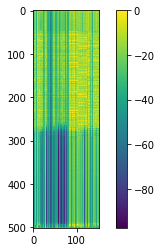

<s>차_______________________________________ᆯ__하_____에____예__ _아______이___다____려_____ _자___________하_____나____ᆼ_헤____여_____ᅡ____ᆫ__몌__________________________________지_______________________________서__ᆼ_이______마______ᆫ_머___가_ᆫ__지___할_이___ᅵ_ _여___ᄋ____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᄒ__나요?</s>
<s>찰하에예 아이다려 자하낭헤여ᅡᆫ몌지성이만머간지할이ᅵ 여ᄋᄒ나요?</s>
<s>삼성카드 6만원이상 결제하면 3만원 현장할인되잖아요. SKT통신사 할인도 같이 할 수 있는건가요?</s>_____________________________________________________


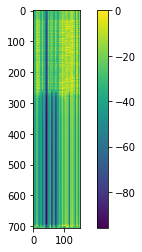

-------------------------------------------------------------------------------------------------------
09-20 11:35:09
09-20 11:39:20
Mean Train Loss: 0.025567555675823687
Train CER: 0.5032666032568671
09-20 11:39:35
Mean Evaluation Loss: 0.02347439759815696
Evaluation CER: 0.4735981868503062


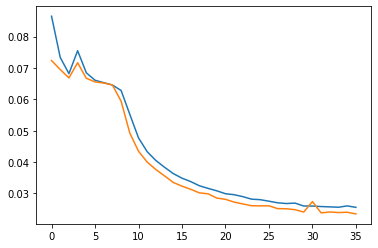

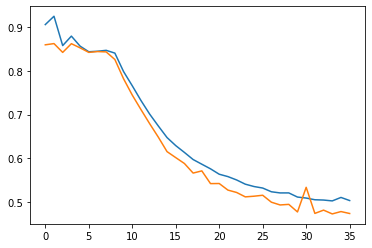

<s>예_________________________________________야__ᆨ_ 시______가____ᆫ___버____다____으_ᆯ_  ᄉ______시_____________________  바_____오___ _치____서_____________________________________________________________________________________________________________________________________________________________________________________될까요?</s>
<s>예약 시간버다을 ᄉ시 바오 치서될까요?</s>
<s>예약 시간 보다 늦을시 바로 취소되나요?</s>____


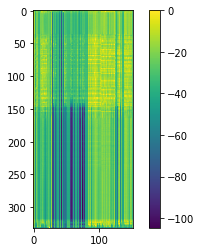

<s>아_______________________________________________________________사___________________   아_____우_ᆺᆺ___보___ 예___ᄋ야__ᆨ_으__________  바_____요__ᆼ___대___________느__ᆫ____기______________________ _이___ᄋ_______이____ 아____ᆻ_느_ᆫ___지___에____아_____ᄋ______어______ᅭ______________________________________  예_____ᄋ___ᆨ_하_____ᆯ이_____여_______ᆼ_ 부____바_ᆨ____ᅳ_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________립니다.</s>
<s>아사 아웃보 예약으 바용대는기 이ᄋ이 았는지에아ᄋ어ᅭ 예ᄋᆨ할이영 부박ᅳ립니다.</s>
<s>제가 다음주 예약을 토요일에 했는지 일요일에 했는지 헷갈려서요. 예약 확인 좀 부탁드립니다.</s>____________________________________________________________


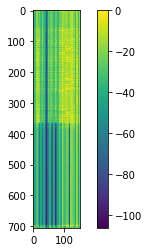

-------------------------------------------------------------------------------------------------------
09-20 11:39:35
09-20 11:43:49
Mean Train Loss: 0.02491075599266903
Train CER: 0.4924067142735782
09-20 11:44:02
Mean Evaluation Loss: 0.023214874660113533
Evaluation CER: 0.46793209405714037


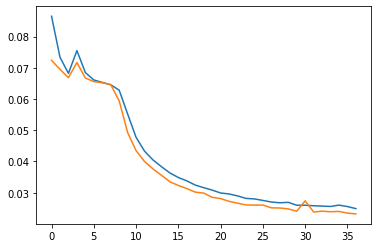

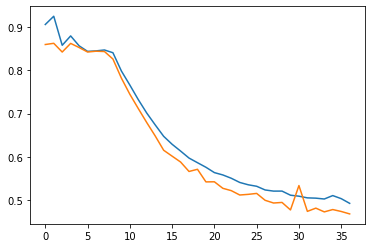

<s>새______________________________________________________________________________________________시____그_ᆫ___도_____라__ᆫ__치__________드___ _주____무___ᄋ___ 가______ᄂᄂ________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________하_가요?</s>
<s>새시근도란치드 주무ᄋ 가ᄂ하가요?</s>
<s>지금도 런치 세트 주문 가능한가요?</s>________


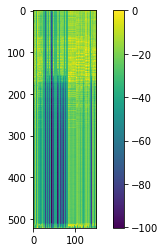

<s>아_____________________________________________________________________우_ᆺᆺᆺ__배_ᆨᆨ_에___   저_____나_____에__ 거____어____시_________데_____________________  자_______뫄___ᆫ_이_______자___러_____도___으___  다___ᆫ__가____스_게______ 아______기__아_ᆫ_에____ᅵ____저________이___다________________________________  어____떻ᇂ_게__ 가__ᆫ____이____제_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________건가요?</s>
<s>아웃백에 저나에 거어시데 자뫈이자러도으 단가스게 아기안에ᅵ저이다 어떻게 간이제건가요?</s>
<s>아웃백에 전화를 걸었을 때 점원이 여러분을 반갑게 맞이하며 인사합니다. 어떻게 답례하실건가요?</s>_______________________________________________________


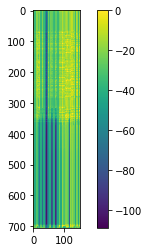

-------------------------------------------------------------------------------------------------------
09-20 11:44:03
09-20 11:48:19
Mean Train Loss: 0.025305743682303473
Train CER: 0.4998517403687304
09-20 11:48:32
Mean Evaluation Loss: 0.02355462539113989
Evaluation CER: 0.467844923398784


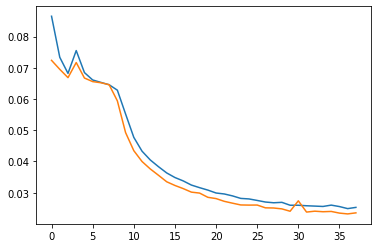

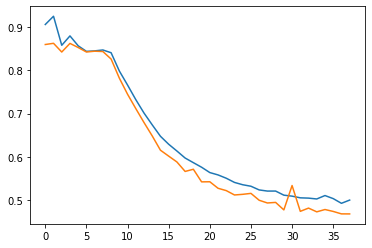

<s>다________________________________________________ᅵ_ᆫ___므_ᆫ__느___시___________ 하___ᆯ이___ᆫ_으____ 가___ᆮ으_ᆯ  수________________________________________________________________________________________________________________________________________________________________________ 이ᅵᆻ나요?</s>
<s>다ᅵᆫ믄느시 할인으 갇을 수 있나요?</s>
<s>따로 멤버십 할인을 받을 수 있나요?</s>____


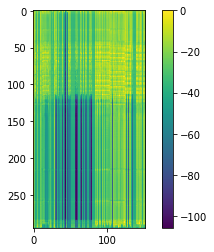

<s>처__________________________________ᅡ______ 하______에___오____마______에___나____애_______차______ᅡ____가____마___하___매___하___하__느_ᆫ__에____ᅣ______________________이_____지______이_____________________ _토____이______가________로___가____사___________이_ _여________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________하_아요?</s>
<s>처ᅡ 하에오마에나애차ᅡ가마하매하하는에ᅣ이지이 토이가로가사이 여하아요?</s>
<s>삼성카드 6만원이상 결제하면 3만원 현장할인되잖아요. SKT통신사 할인도 같이 할 수 있는건가요?</s>_____________________________________________________


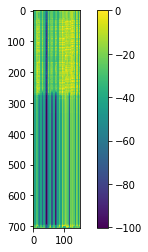

-------------------------------------------------------------------------------------------------------
09-20 11:48:33
09-20 11:52:51
Mean Train Loss: 0.02530113859818842
Train CER: 0.49545009625518516
09-20 11:53:05
Mean Evaluation Loss: 0.02380387613917238
Evaluation CER: 0.47778237845141325


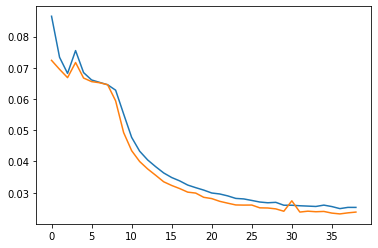

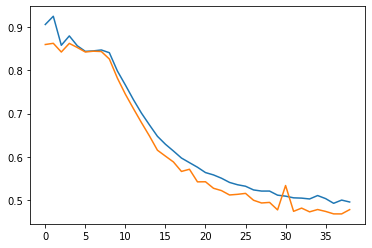

<s>예________________________________________야___사_____티___________이_____ 이_ᄋ___ 흐____마___고___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________한가요?</s>
<s>예야사티이 이ᄋ 흐마고한가요?</s>
<s>예약할 때 미리 예약금 걸어야 하나요?</s>_____


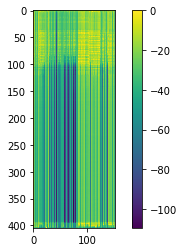

<s>자_______________________________________ᆯ_ 가_____에____우___ᄋ아______이_  가____에_______에_____ᅡ_____하____나_____ᆼ_에ᅦ___으__________ᆫ__메__________________________________지_______________________________토____이______하______ᆼ 머___가___ 자_______ᄋ_______ᄋ_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 었나요?</s>
<s>잘 가에우아이 가에에ᅡ하낭에은메지토이항 머가 자ᄋᄋ 었나요?</s>
<s>삼성카드 6만원이상 결제하면 3만원 현장할인되잖아요. SKT통신사 할인도 같이 할 수 있는건가요?</s>_____________________________________________________


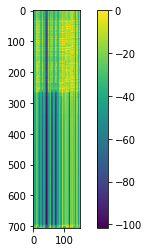

-------------------------------------------------------------------------------------------------------
09-20 11:53:06
09-20 11:57:20
Mean Train Loss: 0.024823598590789673
Train CER: 0.49043267884992203
09-20 11:57:33
Mean Evaluation Loss: 0.02292345532140441
Evaluation CER: 0.4592586135506788


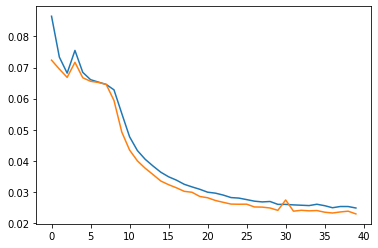

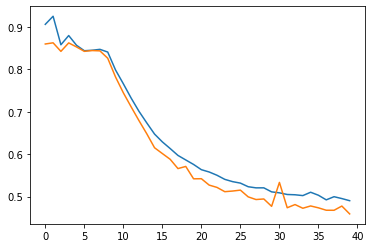

<s>오_______________________________느_ᆯ__시__ᆼ__일__이__ᆫ___데________________ _지___그_____ᆷ_ 여__ᆼᆼ어__ᆸ___하______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________시나ᅡ요?</s>
<s>오늘싱일인데 지금 영업하시나요?</s>
<s>오늘 휴일인데 지금 영업하시나요?</s>________


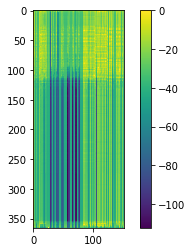

<s>아_____________________________________________우____배_ᆨᆨ_이_ᆯ 저_______나___으_ᆯ  거________ᅡ_ 스_____ᆻ____떼________  저_______머___ᆫ_이_  여___어_____으___느__ 가______느__까_______기_____마______이_ ᄋ아____여___이__ᆻ___져___아____이___다____________  어_____떠__ᆨ___게____  가______ᆫ___게___하ᅡ_ᆫ_시________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________건가요?</s>
<s>아우백일 저나을 거ᅡ 슸떼 저먼이 여어으느 가느까기마이 아여있져아이다 어떡게 간게한시건가요?</s>
<s>아웃백에 전화를 걸었을 때 점원이 여러분을 반갑게 맞이하며 인사합니다. 어떻게 답례하실건가요?</s>_______________________________________________________


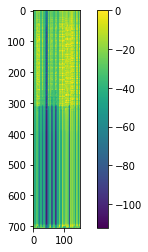

-------------------------------------------------------------------------------------------------------
09-20 11:57:34
09-20 12:01:45
Mean Train Loss: 0.024481982424609902
Train CER: 0.4886380658497858
09-20 12:01:59
Mean Evaluation Loss: 0.023068969347936095
Evaluation CER: 0.46542593762939394


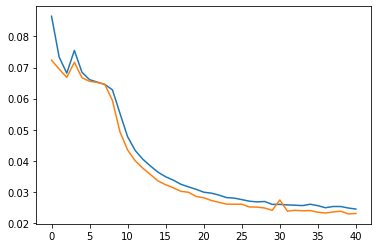

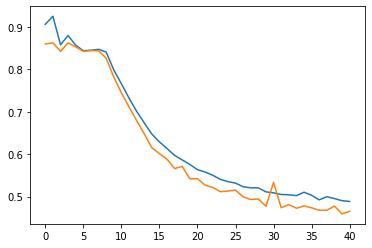

<s>더_____________________________________________ᆫ___치___  타_____이_ᆷ_에__________  예___야ᅣᆨᆨ__ 가_____능___ᅳ_____________________________________________________________________________________________________________________________________________________________________ᆼ___지죠?</s>
<s>던치 타임에 예약 가능ᅳᆼ지죠?</s>
<s>런치 타임에 예약 가능한지요?</s>_


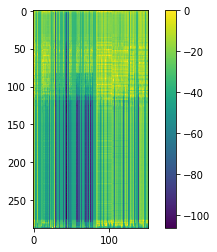

<s>아______________________________________________________________거_____________________  아____ᄋ_ᅮ______조____ᄋ____ᄋ야__ᆨ_으__________  버_____여__ᆫ___데_________ _느_______이______________________ _ᄋ____ᄋ_______이_____새______느_ᆫᆫ__세___에_ᆨ__파_____려_____서______ᅭ______________________________________  예_____야__________ᆯᆯ이__ᆼ___ᄌ_________ 부____하_ᆨ___ᅳ______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________립니다.</s>
<s>아거 아우조ᄋ약으 버연데 느이 ᄋᄋ이새는세엑파려서ᅭ 예얄잉ᄌ 부학ᅳ립니다.</s>
<s>제가 다음주 예약을 토요일에 했는지 일요일에 했는지 헷갈려서요. 예약 확인 좀 부탁드립니다.</s>____________________________________________________________


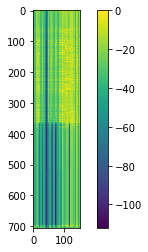

-------------------------------------------------------------------------------------------------------
09-20 12:02:00
09-20 12:06:12
Mean Train Loss: 0.025282342871178226
Train CER: 0.4981601126400511
09-20 12:06:25
Mean Evaluation Loss: 0.023051524276737102
Evaluation CER: 0.46815002070303136


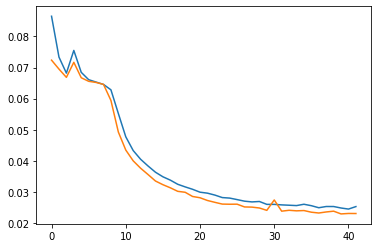

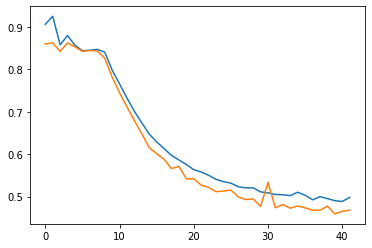

<s>내____________________________________________________니__ _도____________시_____예___ᄋ야_ᆨ_가______느__________________________________________________________________________________________________________________________________________ᆼᆼᄒ한가요?</s>
<s>내니 도시예약가능한가요?</s>
<s>애기 돌잔치 예약 가능한가요?</s>


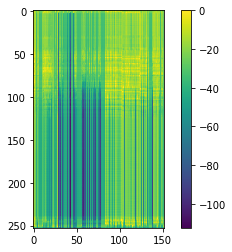

<s>바__________________________________ᆼ___차_______가______스_____테____이____트_______  호_____ᆼ___포_____즈__드____마___니_ᆫ___데_________________________________  허____고____ 거____메___이__서___ᆼ_ _주__ᆼ_무_____거_____ᆫ___데_______________  주____모____파___즈__ᆼ___하______이___  가___ᄂ느_____가_____가___ᄋ____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᆻᄌ죠ᅭ?</s>
<s>방차가스테이트 홍포즈드마닌데 허고 거메이성 중무건데 주모파증하이 가느가가ᄋᆻ죠?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


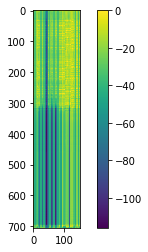

-------------------------------------------------------------------------------------------------------
09-20 12:06:26
09-20 12:10:42
Mean Train Loss: 0.026457583816155223
Train CER: 0.5159072502772275
09-20 12:10:56
Mean Evaluation Loss: 0.02332440688267522
Evaluation CER: 0.46540414496480487


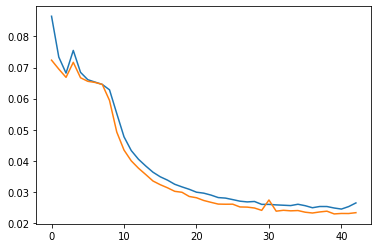

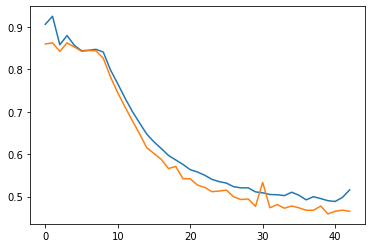

<s>아_________________________________________________오____고______이_____아____로___하___이_  주_______봅ᆨ  가_____ᄅ_ᅵᆫ_ 가____ᄋ_ᅳᆫ  주_____거__ᅮ__핼__새___아__애__  구___ᆼ_느_ᆷ___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________합니다.</s>
<s>아오고이아로하이 주봅ᆨ 가린 가은 주거ᅮ핼새아애 궁늠합니다.</s>
<s>여러분은 여러 가지 중복 할인 가능 조건 (학생 생일 멤버십 등)에 대해 궁금합니다.</s>_________


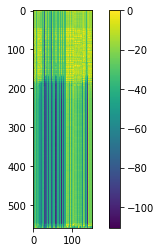

<s>아_______________________________________________________________아____________________  아_____우_ᆺ____배__  예___ᄋ야__ᆨ__으_________  바______느_ᆫ____베__________으___ᆫ___지______________________ _이__이_______이_____새___ᆼ__이_____스___에____하_____여_____서______ᅭ______________________________________  ᄋ예____야_ᆨ _하_______으_____조________ ᄇ브___바_ᆨ___드_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________립니다.</s>
<s>아아 아웃배 예약으 바는베은지 이이이생이스에하여서ᅭ 예약 하으조 브박드립니다.</s>
<s>제가 다음주 예약을 토요일에 했는지 일요일에 했는지 헷갈려서요. 예약 확인 좀 부탁드립니다.</s>____________________________________________________________


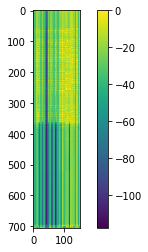

-------------------------------------------------------------------------------------------------------
09-20 12:10:57
09-20 12:15:11
Mean Train Loss: 0.02493803583659349
Train CER: 0.4920861329029191
09-20 12:15:25
Mean Evaluation Loss: 0.023285917595797033
Evaluation CER: 0.46398762176651337


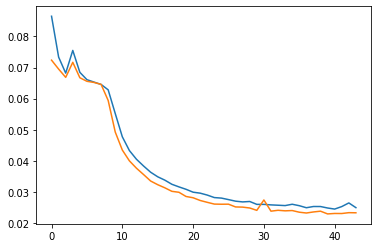

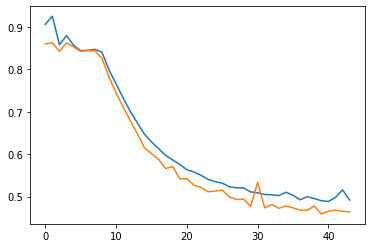

<s>주________________________________________________차_____하___으__ 고_골_시____이____________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 이ᅵᆻ나요?</s>
<s>주차하으 고골시이 있나요?</s>
<s>주차 할 곳이 있나요?</s>___________


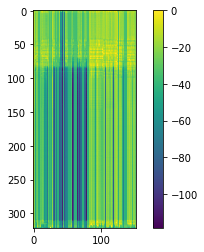

<s>에______________________________________________________________가_____________________  아_____우______배_____예___야__ᆨ_으__________  차_____으___ᆫ_ _데___ ____ __ᄂ__ᆫ____지_____________________   이___ᄋ________이____새______느_ᆫ___스___에____아_____에_____어_____요______________________________________  예ᅨ____야__ᆨ_하______이__ᆫ___저_________부____바_ᆨᆨ__드_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________립니다.</s>
<s>에가 아우배예약으 차은 데  ᄂᆫ지 이ᄋ이새는스에아에어요 예약하인저부박드립니다.</s>
<s>제가 다음주 예약을 토요일에 했는지 일요일에 했는지 헷갈려서요. 예약 확인 좀 부탁드립니다.</s>____________________________________________________________


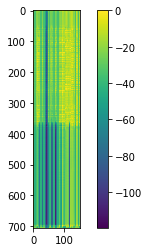

-------------------------------------------------------------------------------------------------------
09-20 12:15:25
09-20 12:19:39
Mean Train Loss: 0.025444757249001936
Train CER: 0.5007938727007649
09-20 12:19:54
Mean Evaluation Loss: 0.023490303921698392
Evaluation CER: 0.4708741037766688


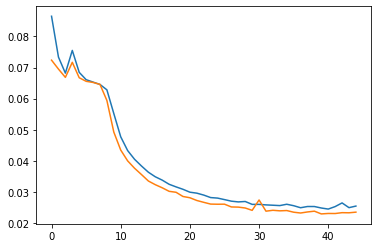

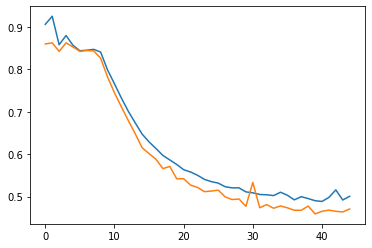

<s>에__________________________________________________________가_____________ᅵ_____초____포_________저___ᆫ__겨__요___ᄉ_______________________________________기___ᄋ____ᆫ_ _저______녀__ᆨ_시_____가___ᆫ_이__다______가_______ᆫ___가_____느____데___ᆫ___데_________________ _지______고_____도__ᆼ____자___ᆯ이__저__ᆯ리_______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________른가요?</s>
<s>에가ᅵ초포전겨요ᄉ기ᄋᆫ 저녁시간이다간가느덴데 지고동잘이절리른가요?</s>
<s>제가 아직 초보 운전이라서 지금 저녁 시간이라 사람 많을텐데  출구 공간이 넓은가요?</s>__________


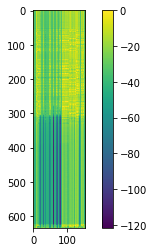

<s>어_____________________________________________우____배__ᆨ_이_ᆯ  저______하___이__  하___________스__________때________   저______머___ᆫ_이_  여___ᄅ______고___려__ _다______ᅳᆫ_가_______기_____마______이___하___ ᄒ____이______자_______ᆷ_이___ᄅ_____________  어_____떠__ᆨ___게____  가__________게___아__ᆨ_기________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________건가요?</s>
<s>어우백일 저하이 하스때 저먼이 여ᄅ고려 다ᅳᆫ가기마이하 ᄒ이잠이ᄅ 어떡게 가게악기건가요?</s>
<s>아웃백에 전화를 걸었을 때 점원이 여러분을 반갑게 맞이하며 인사합니다. 어떻게 답례하실건가요?</s>_______________________________________________________


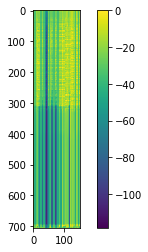

-------------------------------------------------------------------------------------------------------
09-20 12:19:54
09-20 12:24:09
Mean Train Loss: 0.024967747155572637
Train CER: 0.49281241886197047
09-20 12:24:22
Mean Evaluation Loss: 0.023177124948069398
Evaluation CER: 0.4646414017041864


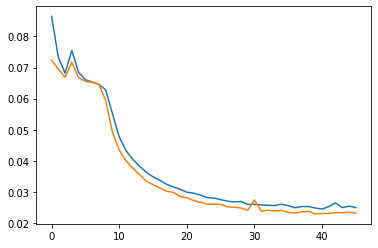

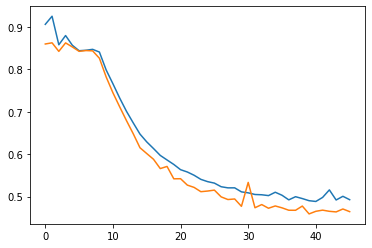

<s>어_____________________________________리_ᆫ__이_ᆫ 메____뉴___가________ _따____로_________________________________________________________________________________________________________________________________________________________________________________  있ᆻ나요?</s>
<s>어린인 메뉴가 따로 있나요?</s>
<s>어린이 메뉴가 따로 있나요?</s>______


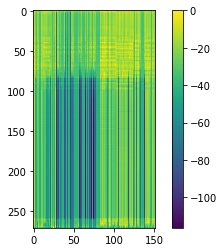

<s>아_____________________________________________________________________ᄋ웃ᆺᆺ__배__ᆨᆨ에___   저_____자_____에__ 거____러____시_________데_____________________  _저______머___ᆫ_이_____ _저____어____도___으_ᆯ_  자___ᆫᆫ_가________기_ᄋ__ᆯ _바_____지_ 하_ᆭ_느___이ᅵᆫ___저____ᆷ__이___다_______________________________   어____떠_ᇂᇂ게_  저__ᆫ  예__야___제____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________건가요?</s>
<s>아웃백에 저자에 거러시데 저먼이 저어도을 잔가기ᄋᆯ 바지 핞느인점이다 어떻게 전 예야제건가요?</s>
<s>아웃백에 전화를 걸었을 때 점원이 여러분을 반갑게 맞이하며 인사합니다. 어떻게 답례하실건가요?</s>_______________________________________________________


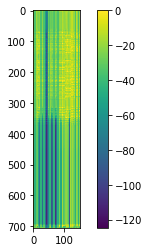

-------------------------------------------------------------------------------------------------------
09-20 12:24:23
09-20 12:28:37
Mean Train Loss: 0.024554583853787705
Train CER: 0.48793389831353906
09-20 12:28:50
Mean Evaluation Loss: 0.023368807142711164
Evaluation CER: 0.467409070107002


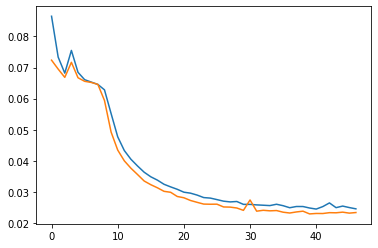

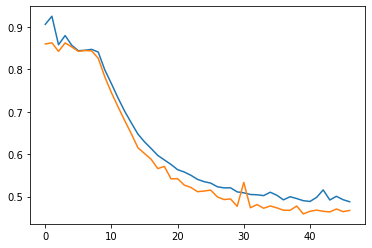

<s>아_______________________________________________________시____ _가__ᆫᆫ___체_ᄒ__하_인ᆫ__도_________________________________________________________________________________________________________________________________________________________ 이ᅵᆻ나요?</s>
<s>아시 간체ᄒ하인도 있나요?</s>
<s>혹시 단체할인도 있나요?</s>______


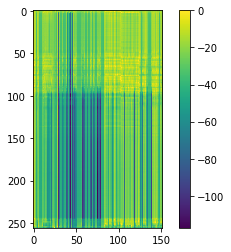

<s>아___________________________________________________배__ᆨ_이_ᆯ  저_____하___ᆼ에___ 가___ᆼ_어___ 시_______ᅳ__대________  저____ᆼ__어___ᆫ_이_  요____ᄋ___ _으___에__ 다_____ᆼ웅 가_______이___  마______이   아____ᄋ__ᆯ 이_ᆻᆻ___자__ᄋᄋ___ᆼ_이___아____________  어_____떠__ᇂᇂ__게____  가______ᆫ___게___하__ᆨ기_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________건가요?</s>
<s>아백일 저항에 강어 시ᅳ대 정언이 요ᄋ 으에 당웅 가이 마이 아ᄋᆯ 있자ᄋᆼ이아 어떻게 간게학기건가요?</s>
<s>아웃백에 전화를 걸었을 때 점원이 여러분을 반갑게 맞이하며 인사합니다. 어떻게 답례하실건가요?</s>______________________________________________________

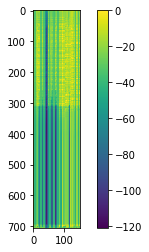

-------------------------------------------------------------------------------------------------------
09-20 12:28:51
09-20 12:33:07
Mean Train Loss: 0.024695944125696742
Train CER: 0.4885516433628562
09-20 12:33:20
Mean Evaluation Loss: 0.023880501295717147
Evaluation CER: 0.4737425461639068


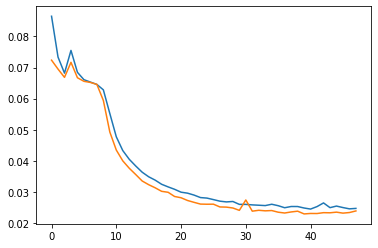

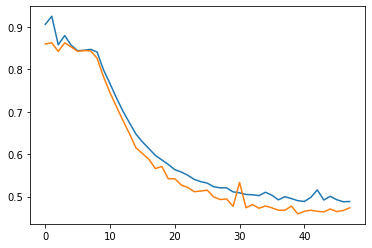

<s>거________________________________________________________기__ᄋ야_____으__ᄋ예__야___ 식_사________ 가____느_ᆼ하_ᆫ__가___아___________________________________  어_ᄋ__ᆷ___지___애__하___시_ᆨ_시____사__ᄒᄒ_ᄅ__려_ᆷ_____ _대__________  예__ᄋ야_ᆨ_야___며__ᅩ__가___도__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

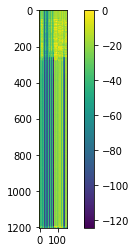

<s>저___________________________________마___ᆯ_에__ _자____ 이___가___조____고__ 그______자____니____느_ᆫ___데_____________________따___가__  가_____며____ᅡ___ᆫ_ _자____이ᅵ__ 조___ᆷ___주____우__ᆷ___됴____________________________ 아___ᆫ___네__ᄒ__ _주___시_ᆯ __수 _ᅵᅵ__주__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________세요.</s>
<s>저말에 자 이가조고 그자니는데따가 가며ᅡᆫ 자이 좀주움됴 안네ᄒ 주실 수 ᅵ주세요.</s>
<s>저번에 자리가 조금 불편했는데 있다가 가면 자리 좀 좋은데로 안내 해 주실 수 있으세요?</s>________________


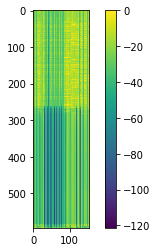

-------------------------------------------------------------------------------------------------------
09-20 12:33:21
09-20 12:37:34
Mean Train Loss: 0.024690983376442037
Train CER: 0.4905769201959521
09-20 12:37:48
Mean Evaluation Loss: 0.02509534797120748
Evaluation CER: 0.4873057728768497


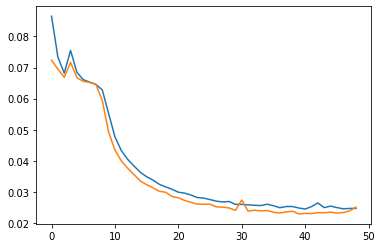

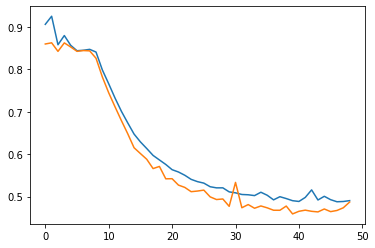

<s>아____________________________________________체____ᄋ__________ᅮ___ᅵ_____모______가__ 거_____ᅩᆷ_하___려___고___ᅳᆫ__데____요______________________  아_____이__디____려________로___고___그__ _ᅳ____데____ᅩ__  _시_______ᅩ____ᅦ__리___ᅵ______ᅦ___주__ᆫ__비___저________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 이ᅵᆻ나요?</s>
<s>아체우ᅵ모가 거ᅩᆷ하려고ᅳᆫ데요 아이디려로고그 ᅳ데ᅩ 시ᅩᅦ리ᅵᅦ준비저 있나요?</s>
<s>네 조금 이따 방문하려고 하는데요. 아이를 데려가려고 하는데 혹시 베이비 시트가 준비되어 있나요?</s>


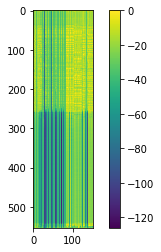

<s>그_________________________________________________________ᆫ____처____________  호____시_______데____이____로___고____시____ᄋ_____가_____요_________________ _시_______아___우_ᆺᆺᆺ___배_ᆨ__시______  가_______녀____에___요________스_____버__ᆫ___치_____부____초__ᆼ__이______마____요_________________________________________  이_____치____가_____ᆼ _으__ᆯ__여____  저______가___ᆨ___주__ᆷ___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________인가요?</s>
<s>근처 호시데이로고시ᄋ가요 시아웃백시 가녀에요스번치부총이마요 이치강 을여 저각줌인가요?</s>
<s>근처에 버스 내리는 곳이 있나요? 아웃백이 강남역 5번 출구 쪽인가요? 위치가 골목 바깥 쪽인가요?</s>________________________________________________________


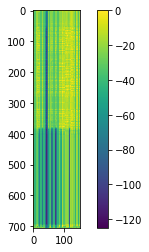

-------------------------------------------------------------------------------------------------------
09-20 12:37:49
09-20 12:42:03
Mean Train Loss: 0.02477351426975302
Train CER: 0.4868259436788496
09-20 12:42:16
Mean Evaluation Loss: 0.022888814570911034
Evaluation CER: 0.4532002527949092


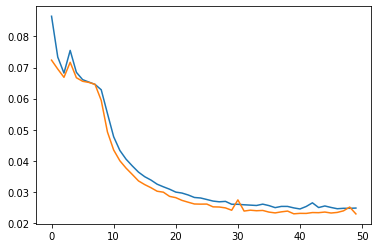

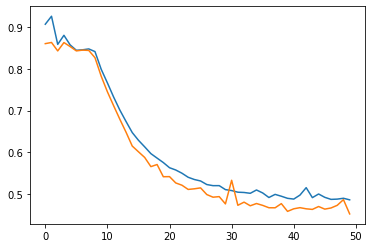

<s>여__________________________________ᆼᆼ_업ᆸ__시_____가_ᆫ_이____에____ᅵ________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________같나요?</s>
<s>영업시간이에ᅵ같나요?</s>
<s>영업시간이 매일 같나요?</s>______


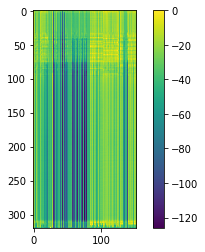

<s>오______________________________________ᆫ___녀_ᆼ하____제____요___ᄋ__ᆫ__여____서____하_____게__ᄋ___스__고_ _저__ᆫ_나____이__샀ᆻ_는ᆫ___데___요_________________________   헉ᆨ_시_____아____ᄋ웃____배_ᆨᆨ__이_____에____모___ᆫ___시___엔__가____지____보__ _자___러_ _거__드__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 되나ᅡ요?</s>
<s>온녕하제요ᄋᆫ여서하게ᄋ스고 전나이샀는데요 헉시아웃백이에몬시엔가지보 자러 거드 되나요?</s>
<s>안녕하세요. 여쭤볼게 있어서 전화드렸는데요. 혹시 아웃백에 외부 음식을 가지고 들어가도 되나요?</s>____________________________________________________________


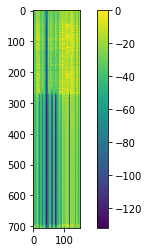

-------------------------------------------------------------------------------------------------------
09-20 12:42:17
09-20 12:46:33
Mean Train Loss: 0.026147602875792535
Train CER: 0.5166690777757269
09-20 12:46:46
Mean Evaluation Loss: 0.023847393544374505
Evaluation CER: 0.47745548848257674


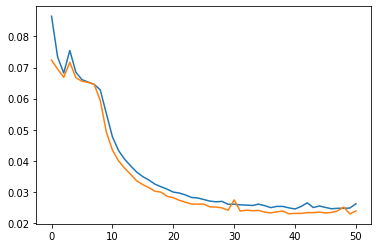

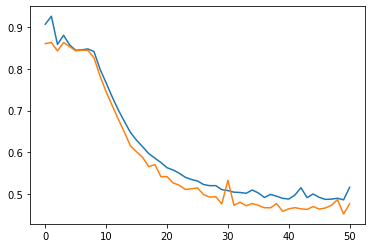

<s>그__________________________________________________________ᆫᆫ___차________  그____차___ 자__ᆫ__기________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ ᄋ있나요?</s>
<s>근차 그차 잔기 있나요?</s>
<s>근처에 주차장이있나요?</s>_______


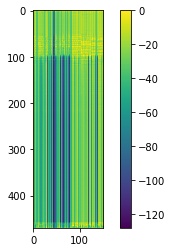

<s>그__________________________러_ᆫ___체______가___________ᅦ___ 스___케___이___테___________  구______ᅳ_ 부____ᅳᆫ__즈____느_ᆫ__바_____므_ᆫᆫ__데____________  쿠_______보_______ 브_____메____이____저____ᆼ_ _주____므__ᆫ__거_____으___데_______ _______시____고____ _보___르______트__  가____ᄋ이__ᆫ__  바____느_ᆫ_하___다____는ᆫ 마__ᆯᆯ _시______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________있ᄌ죠ᅭ?</s>
<s>그런체가ᅦ 스케이테 구ᅳ 부ᅳᆫ즈는바믄데 쿠보 브메이정 주믄거으데 시고 보르트 가인 바는하다는 말 시있죠?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>_____________________________________________________

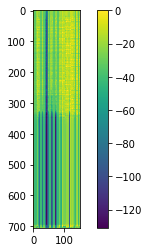

-------------------------------------------------------------------------------------------------------
09-20 12:46:47
09-20 12:51:03
Mean Train Loss: 0.025430391187561158
Train CER: 0.5000174970255057
09-20 12:51:16
Mean Evaluation Loss: 0.02371151153030292
Evaluation CER: 0.4701985311744067


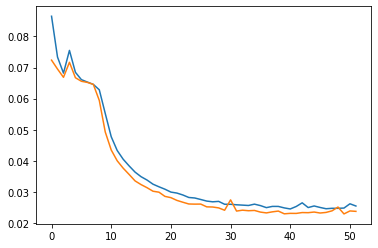

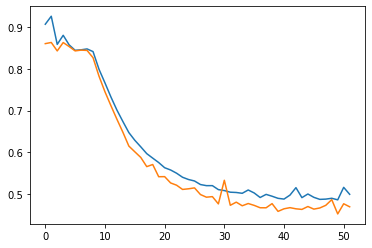

<s>주_________________________________________________________자____시___마_ᆫ_ 며_ᆾ_시____가_ᆫ__ᅵ_____________________________________________________________________________________________________________________________________________________________________해요?</s>
<s>주자시만 몇시간ᅵ해요?</s>
<s>주차시간 몇시간이에요?</s>_________


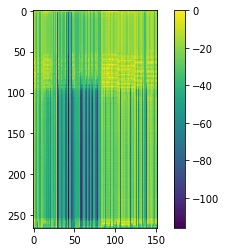

<s>아_____________________________________________우_ᆺ__배_ᆨᆨ_이__ _저______마_____ᅦ_ᆫ 하______ᅥ____시___________애________  저______오_____이____요___어____무___레__  바_________마_______기__ᆼ__마___ᆫ___ᅵᅵ   하___ᄋ____이__ᆻ___자_______ᆼ_이___다____________  어_____떠__ᇂ___게__ᅦ_  가______ᆷ___게___아____기________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________건가요?</s>
<s>아웃백이 저마ᅦᆫ 하ᅥ시애 저오이요어무레 바마깅만ᅵ 하ᄋ있장이다 어떻게ᅦ 감게아기건가요?</s>
<s>아웃백에 전화를 걸었을 때 점원이 여러분을 반갑게 맞이하며 인사합니다. 어떻게 답례하실건가요?</s>_______________________________________________________


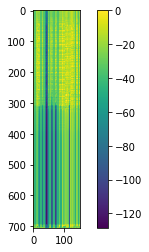

-------------------------------------------------------------------------------------------------------
09-20 12:51:17
09-20 12:55:29
Mean Train Loss: 0.02538299691816246
Train CER: 0.5002259669763621
09-20 12:55:44
Mean Evaluation Loss: 0.023838166039245698
Evaluation CER: 0.4863686882995184


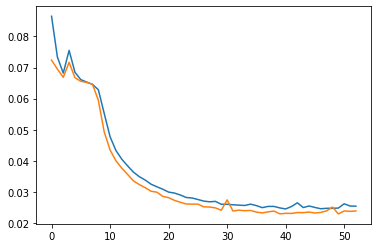

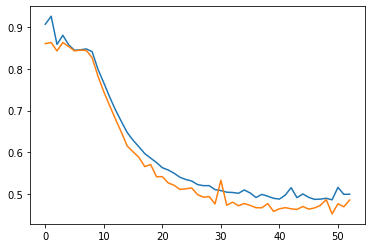

<s>에__________________________________________________세________이ᅵ____나_______ᅭ__________________ _ᅡ_______ᅢ____디_______서___________ᅩ______배_____메____뉴___가________나___ᄋ_ᅭ________________________  여________느___________  여_____여____며ᅧ____ᅡ___ᆫ__마_____ᆻ__느_ᆫ__메____뉴___므___ 뭐__ᆺ_ᄀ_______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ _웠나요?</s>
<s>에세이나ᅭ ᅡᅢ디서ᅩ배메뉴가나요 여느 여여며ᅡᆫ맜는메뉴므 뭣ᄀ 웠나요?</s>
<s>매운 음식이 있나요? 채식주의자가 먹을 메뉴가 있나요? 여름에만 나오는 메뉴는 뭐가 있나요?</s>_____


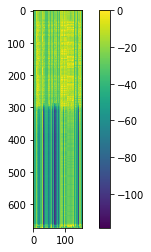

<s>자________________________________ᄅ________ 하________________아_______이___가___르______ 시___________ᄒ_ᅡ____며____ᆼ _하____여__________ᆫ _미___아_____________________________키_____________________________  소____ᄋ___ᅵ__나_________모___하____새____ᅡ___ᅵ__이__이________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 인가요?</s>
<s>자ᄅ 하아이가르 시하명 하연 미아키 소이나모하새ᅡᅵ이이 인가요?</s>
<s>삼성카드 6만원이상 결제하면 3만원 현장할인되잖아요. SKT통신사 할인도 같이 할 수 있는건가요?</s>_____________________________________________________


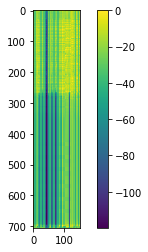

-------------------------------------------------------------------------------------------------------
09-20 12:55:44
09-20 12:59:57
Mean Train Loss: 0.026601280081479096
Train CER: 0.5181130747165892
09-20 13:00:10
Mean Evaluation Loss: 0.023496501881369383
Evaluation CER: 0.46937040992002094


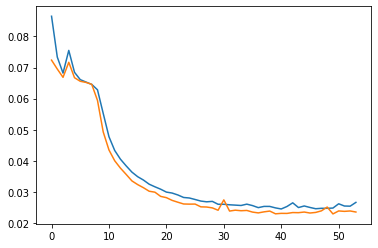

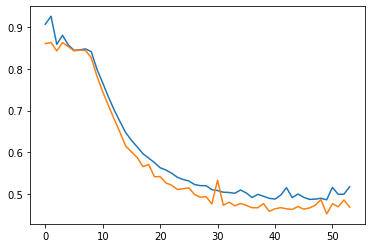

<s>며_________________________________________________ᆾ__시__부____터  어___버____시___가_ᆫ____________________________________________________________________________________________________________________________________________________인가요?</s>
<s>몇시부터 어버시간인가요?</s>
<s>몇시 부터 오픈 시간 인가요?</s>___


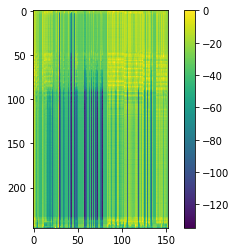

<s>그_________________________________________________________ᆫᆫ___처______________허____스_______데__________로___고____시______ᅵᆻ_나_________________________  ________ 어____웃_____매_____시_____ _가____ᆫ_나__ᆫ__이___라_____  무______바__ᆫ___치______투___토__ᆨ__기_____ᅡ__________________________________________________ 미_____시_____가_______그____ 오____ _저__ᆨ___파_______쪼______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________이ᄂ나요?</s>
<s>근처허스데로고시ᅵᆻ나  어웃매시 간난이라 무반치투톡기ᅡ 미시가그 오 적파쪼이나요?</s>
<s>근처에 버스 내리는 곳이 있나요? 아웃백이 강남역 5번 출구 쪽인가요? 위치가 골목 바깥 쪽인가요?</s>________________________________________________________


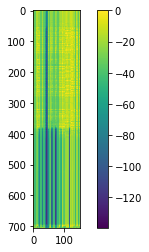

-------------------------------------------------------------------------------------------------------
09-20 13:00:11
09-20 13:04:26
Mean Train Loss: 0.02807933245044487
Train CER: 0.539787593507199
09-20 13:04:39
Mean Evaluation Loss: 0.025406012711953807
Evaluation CER: 0.49663303332098413


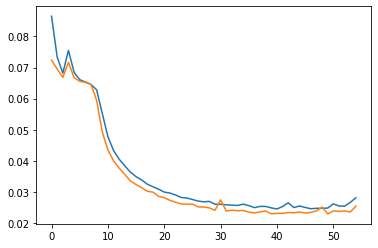

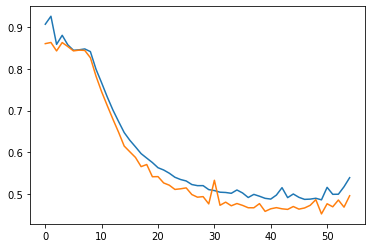

<s>아_____________________________________니__  가___ᆷ___자_____ᆸ__이___차____________  호_ᆨ_시_________ᅳ________매_________   자______이_ᆫ__드___ᅩ_   예___야_ᆨᆨ__이___ᆻᆻ_네_ᆫ__뎌____ᆫ  주______녀_____이___어___ 바__ᆯᆯ__거_____하_ᆨᆨ___으_ᆫ___데______ᄂ노____기_____으____로_____ ᄀ가____느__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᆼᄒ한가요?</s>
<s>아니 감잡이차 혹시ᅳ매 자인드ᅩ 예약있넨뎐 주녀이어 발거학은데노기으로 가능한가요?</s>
<s>아 네 감사합니다! 혹시 그때 4인으로 예약했는데 2명이 더 갈 거같은데 6인으로 가능한가요?</s>_____


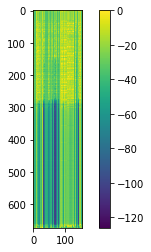

<s>르______________________________ᄅ___ᆷ___차_______바____ _스_____케____이___크_____ᅦ_____ᅩ_____ᆫ___코_____즈__드____마___느_ᆫ___데_________________________________  오___드___ᆫ__거____메___이__사___ᆼ_ _주____마_ᆫ___버_________데________________ _지___모____파___즈_ᆫᆼ___하______이___  가____능__ᅡ 가__ᅳ__가___으____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᄌᄌ죠?</s>
<s>르ᄅᆷ차바 스케이크ᅦᅩᆫ코즈드마는데 오든거메이상 주만버데 지모파즌ᆼ하이 가능ᅡ 가ᅳ가으죠?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


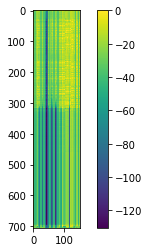

-------------------------------------------------------------------------------------------------------
09-20 13:04:40
09-20 13:08:56
Mean Train Loss: 0.027220829368636658
Train CER: 0.5265211388783289
09-20 13:09:09
Mean Evaluation Loss: 0.024971638328461995
Evaluation CER: 0.4950857541351581


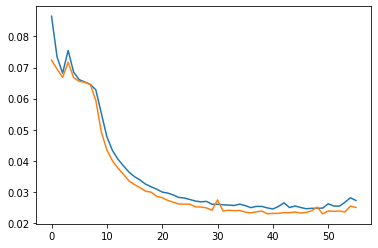

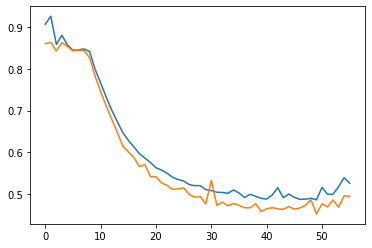

<s>아__________________________________리____ᅵ___어________________________ 가___ᄅᄅ______주____이___ᅵ_ 주___ᄋ_ᅮ____느_____ᅢ___조____ 주_____거__수_____루___가________시_____________ᆫ_________________________________ _그__ᄅᄅ_________________________ _채___하___ 주____차________차___ᄅ__ ᄋ_____먀___사_____가___그_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________가요?</s>
<s>아리ᅵ어 가ᄅ주이ᅵ 주우느ᅢ조 주거수루가신 그ᄅ 채하 주차차ᄅ ᄋ먀사가그가요?</s>
<s>아닙니다. 그럼 치즈케익 메뉴도 추가 주문하고 싶습니다. 그리고 제가 직접

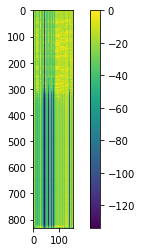

<s>르______________________________러__ᆷ___ᄌ________ᄇ_____ 사______체____ᄋ_____트___ᄋ_____고_________코_____즈__드____가____ᅳ_ᆫᆫ__데_________________________________  코___드_ᄅ___ 거____에___이__서___ᆼ_ _주____부_____버___는___대_______________  _치___오____바___즈__ᆼ___다______이___ _가___느_ᆼ_ᅡ__가_____가_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᄌᄌ죠?</s>
<s>르럼ᄌᄇ 사체ᄋ트ᄋ고코즈드가ᅳᆫ데 코드ᄅ 거에이성 주부버는대 치오바증다이 가능ᅡ가가죠?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


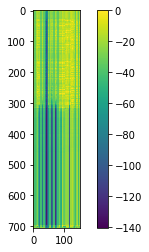

-------------------------------------------------------------------------------------------------------
09-20 13:09:10
09-20 13:13:23
Mean Train Loss: 0.02724160206875163
Train CER: 0.5226444209180616
09-20 13:13:37
Mean Evaluation Loss: 0.02946602274061499
Evaluation CER: 0.5525312179920239


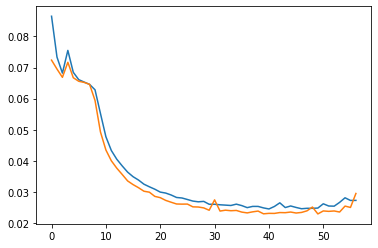

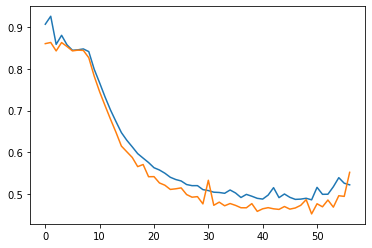

<s>새_____________________________________________규____ᆼ_ 사____ 저___ᆫ_며______사____이_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 이ᅵᆻ나요?</s>
<s>새귱 사 전며사이 있나요?</s>
<s>지금 5명 자리 있나요?</s>__________


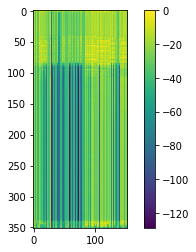

<s>아___________________________________________________배_ᆨᆨ_이__ 서_____ᆫ_하___으___ 가_____하____시_______ᅳ__태____이___ 저_____ᆼ_어___ᆼ_이___요__________으___려__ 가_______ᅳ__하_______기_____마______기 _ 히____이_ᆯ 이______져_______ᆼ_기___ᄃ_____________  어_____터___ᇂᇂ_게__ᅦ__ 가__________에___야____시________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________건가요?</s>
<s>아백이 선하으 가하시ᅳ태이 정엉이요으려 가ᅳ하기마기  히일 이졍기ᄃ 어텋게ᅦ 가에야시건가요?</s>
<s>아웃백에 전화를 걸었을 때 점원이 여러분을 반갑게 맞이하며 인사합니다. 어떻게 답례하실건가요?</s>_______________________________________________________


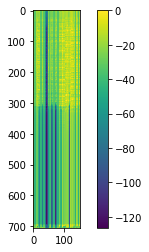

-------------------------------------------------------------------------------------------------------
09-20 13:13:38


KeyboardInterrupt: 

In [20]:
EPOCH = 12 * 6     
           
# net = Mel2SeqNet(80, 512, 256)

net = Mel2SeqNet(80, 1024, 512, len(unicode_jamo_list), device)

net_optimizer = optim.Adam(net.parameters(), lr=0.001)

ctc_loss = nn.CTCLoss().to(device)

keyword = 'NSML_2nd'

train_loss_history = list()
eval_loss_history = list()

train_cer_history = list()
eval_cer_history = list()

try:
    train_cer_history = list(np.load('model_saved/train_cer_history{}.npy'.format(keyword)))
    eval_cer_history = list(np.load('model_saved/eval_cer_history{}.npy'.format(keyword)))
except:
    print("No CER Record")

try:
    load(net, net_optimizer, 'model_saved/{}'.format(keyword))
    train_loss_history = list(np.load('model_saved/train_loss_history_{}.npy'.format(keyword)))
    eval_loss_history = list(np.load('model_saved/eval_loss_history_{}.npy'.format(keyword)))
except:
    print("Loading {} Error".format(keyword))


for epoch in range(EPOCH):

    print((datetime.now().strftime('%m-%d %H:%M:%S')))

    preloader_train.initialize_batch(num_thread)
    loss_list_train = list()

    total_dist = 0
    total_length = 0
#     count = 0
    while preloader_train.end_flag == False:
        batch = preloader_train.get_batch()
        # logger.info("Got Batch")
        if batch != None:
            tensor_input, ground_truth, loss_mask, length_list, lev_truth_list = batch
            pred_tensor, loss = train(net, net_optimizer, ctc_loss, tensor_input.to(device),
                                      ground_truth.to(device), loss_mask.to(device), length_list.to(device))
            loss_list_train.append(loss)
            
            lev_pred_list = Decode_Prediction(pred_tensor, tokenizer, char2index)
            lev_str_list = lev_num_to_lev_string(lev_truth_list, index2char)
            dist, length = char_distance_list(lev_str_list, lev_pred_list)
            total_dist += dist
            total_length += length
            
#             print("Loss: {}".format(loss))
#             count += 1
#             print("Train {}/{}".format(count, int(np.ceil(len(wav_path_list_train)/batch_size))))
#             # logger.info("Training")

    train_cer = total_dist / total_length
    train_loss = np.mean(np.asarray(loss_list_train))
    print((datetime.now().strftime('%m-%d %H:%M:%S')))
    print("Mean Train Loss: {}".format(train_loss))
    print("Train CER: {}".format(train_cer))
    train_loss_history.append(train_loss)
    train_cer_history.append(train_cer)
    
    preloader_eval.initialize_batch(num_thread)
    loss_list_eval = list()

    total_dist = 0
    total_length = 0
    
    while preloader_eval.end_flag == False:
        batch = preloader_eval.get_batch()
        if batch != None:
            tensor_input, ground_truth_, loss_mask, length_list, lev_truth_list_ = batch
            pred_tensor_, loss = evaluate(net, ctc_loss, tensor_input.to(device), ground_truth_.to(device),
                                          loss_mask.to(device), length_list.to(device))
            loss_list_eval.append(loss)
            
            lev_pred_list = Decode_Prediction(pred_tensor_, tokenizer, char2index)
            lev_str_list = lev_num_to_lev_string(lev_truth_list_, index2char)
            dist, length = char_distance_list(lev_str_list, lev_pred_list)
            total_dist += dist
            total_length += length
            
    eval_cer = total_dist / total_length
    eval_loss = np.mean(np.asarray(loss_list_eval))
    print((datetime.now().strftime('%m-%d %H:%M:%S')))
    print("Mean Evaluation Loss: {}".format(eval_loss))
    print("Evaluation CER: {}".format(eval_cer))
    eval_loss_history.append(eval_loss)
    eval_cer_history.append(eval_cer)
    
    #####
    
    save(net, net_optimizer, 'model_saved/{}'.format(keyword))
    np.save('model_saved/train_loss_history_{}'.format(keyword), train_loss_history)
    np.save('model_saved/eval_loss_history_{}'.format(keyword), eval_loss_history)
    np.save('model_saved/train_cer_history{}'.format(keyword), train_cer_history)
    np.save('model_saved/eval_cer_history{}'.format(keyword), eval_cer_history)
            
    #####    
    
    plt.figure()
    plt.plot(train_loss_history)
    plt.plot(eval_loss_history)
    plt.show()
    
    plt.figure()
    plt.plot(train_cer_history)
    plt.plot(eval_cer_history)
    plt.show()

    # index is the position of the max probility of the first batch
    # Shape of the pred_tensor: (T, B, 75)
    # Shape of the index: (T)
    _, index = pred_tensor[:, 0, :].max(-1)

    # Change index numbers to character
    sentence = tokenizer.num2word(index.view(-1))

    # Change list to string
    print(''.join(sentence))

    # Remove "blank" and overlapping characters
    index_ = Decode_CTC_Prediction(index)
    sentence_ = tokenizer.num2word(index_)
    print(''.join(sentence_))

    true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
    print(''.join(true_sentence))

    # Plot image
    # detach().cpu().numpy() transforms a tensor on gpu into a numpy matrix
    plt.figure()
    plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
    plt.colorbar()
    plt.show()

    _, index = pred_tensor_[:, 0, :].max(-1)

    sentence = tokenizer.num2word(index.view(-1))
    print(''.join(sentence))
    index_ = Decode_CTC_Prediction(index)
    sentence_ = tokenizer.num2word(index_)
    print(''.join(sentence_))
    true_sentence = tokenizer.num2word(ground_truth_[0, :].detach().numpy().astype(int))
    print(''.join(true_sentence))

    plt.figure()
    plt.imshow(pred_tensor_[:, 0, :].detach().cpu().numpy())
    plt.colorbar()
    plt.show()
        
    print("-------------------------------------------------------------------------------------------------------")
    